# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [3]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

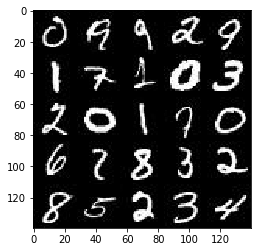

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

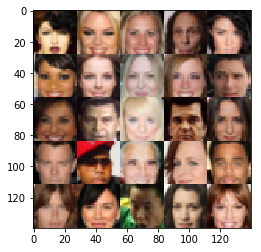

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [6]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_image = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name = 'real_image')
    z_image = tf.placeholder(tf.float32, [None, z_dim], name = 'z_image')
    learning_rate = tf.placeholder(tf.float32, name = 'learning_rate')

    return real_image, z_image, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [31]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.2 * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2 * bn2, bn2)
        # 7x7x128
        
        #x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        #bn3 = tf.layers.batch_normalization(x3, training=True)
        #relu3 = tf.maximum(0.2 * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu2, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [32]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.2 * x1, x1)
        # 7x7x256 now
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        # 14x14x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        # 28x28x64 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xout_dim now
        
        out = tf.tanh(logits)
        
        return out
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [33]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [34]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [35]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [41]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    out_channel_dim = 3 if data_image_mode == "RGB" else 1
        
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
        
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, learn_rate: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 50 == 0:
                    show_generator_output(sess, 9, input_z, out_channel_dim, data_image_mode)   
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.8715... Generator Loss: 0.0278
Epoch 1/2... Discriminator Loss: 3.6568... Generator Loss: 0.0459
Epoch 1/2... Discriminator Loss: 3.2264... Generator Loss: 0.0915
Epoch 1/2... Discriminator Loss: 2.8097... Generator Loss: 0.1903
Epoch 1/2... Discriminator Loss: 2.1487... Generator Loss: 0.3267


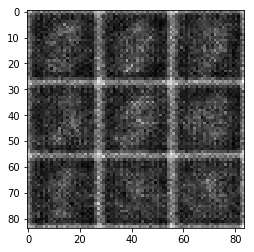

Epoch 1/2... Discriminator Loss: 2.0147... Generator Loss: 0.3703
Epoch 1/2... Discriminator Loss: 1.9998... Generator Loss: 0.3351
Epoch 1/2... Discriminator Loss: 2.0030... Generator Loss: 0.2925
Epoch 1/2... Discriminator Loss: 1.8516... Generator Loss: 0.3642
Epoch 1/2... Discriminator Loss: 1.8656... Generator Loss: 0.3562


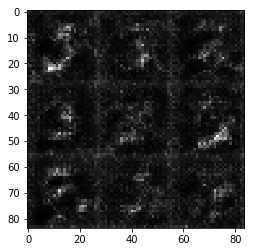

Epoch 1/2... Discriminator Loss: 1.6028... Generator Loss: 0.4443
Epoch 1/2... Discriminator Loss: 1.4529... Generator Loss: 0.5096
Epoch 1/2... Discriminator Loss: 1.4298... Generator Loss: 0.5501
Epoch 1/2... Discriminator Loss: 1.3028... Generator Loss: 0.5963
Epoch 1/2... Discriminator Loss: 1.1695... Generator Loss: 0.7415


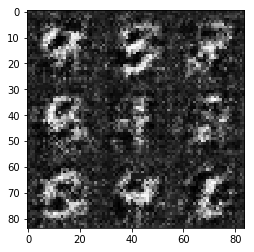

Epoch 1/2... Discriminator Loss: 1.2300... Generator Loss: 0.7372
Epoch 1/2... Discriminator Loss: 1.3334... Generator Loss: 0.5301
Epoch 1/2... Discriminator Loss: 1.2129... Generator Loss: 0.6559
Epoch 1/2... Discriminator Loss: 0.9560... Generator Loss: 1.4895
Epoch 1/2... Discriminator Loss: 0.9580... Generator Loss: 1.3608


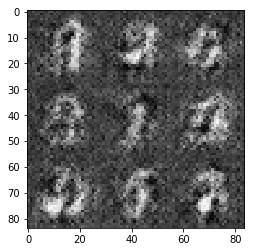

Epoch 1/2... Discriminator Loss: 1.0234... Generator Loss: 0.8292
Epoch 1/2... Discriminator Loss: 1.3547... Generator Loss: 0.6207
Epoch 1/2... Discriminator Loss: 1.1918... Generator Loss: 0.6349
Epoch 1/2... Discriminator Loss: 1.2818... Generator Loss: 0.5633
Epoch 1/2... Discriminator Loss: 1.0930... Generator Loss: 0.7028


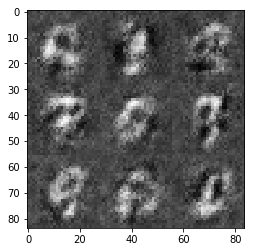

Epoch 1/2... Discriminator Loss: 1.2759... Generator Loss: 0.6083
Epoch 1/2... Discriminator Loss: 1.1954... Generator Loss: 0.6580
Epoch 1/2... Discriminator Loss: 1.1546... Generator Loss: 0.8611
Epoch 1/2... Discriminator Loss: 1.1615... Generator Loss: 0.6589
Epoch 1/2... Discriminator Loss: 1.2477... Generator Loss: 0.6443


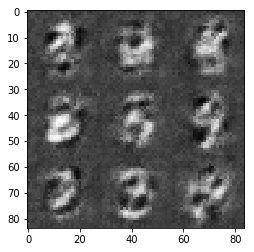

Epoch 1/2... Discriminator Loss: 1.0386... Generator Loss: 0.8515
Epoch 1/2... Discriminator Loss: 1.2657... Generator Loss: 0.6674
Epoch 1/2... Discriminator Loss: 1.1535... Generator Loss: 0.7622
Epoch 1/2... Discriminator Loss: 1.0824... Generator Loss: 0.7937
Epoch 1/2... Discriminator Loss: 1.0783... Generator Loss: 0.8234


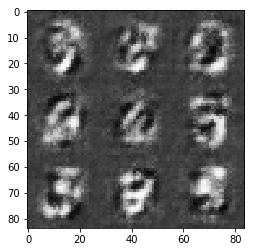

Epoch 1/2... Discriminator Loss: 1.1220... Generator Loss: 0.7597
Epoch 1/2... Discriminator Loss: 1.0980... Generator Loss: 0.8883
Epoch 1/2... Discriminator Loss: 1.0968... Generator Loss: 0.7546
Epoch 1/2... Discriminator Loss: 1.0653... Generator Loss: 0.8396
Epoch 1/2... Discriminator Loss: 1.0303... Generator Loss: 0.9187


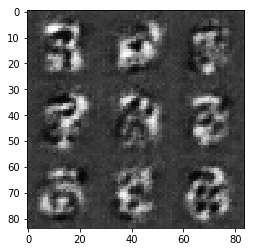

Epoch 1/2... Discriminator Loss: 1.0215... Generator Loss: 0.9737
Epoch 1/2... Discriminator Loss: 1.0197... Generator Loss: 0.7571
Epoch 1/2... Discriminator Loss: 1.0666... Generator Loss: 0.6866
Epoch 1/2... Discriminator Loss: 1.0602... Generator Loss: 0.7941
Epoch 1/2... Discriminator Loss: 0.9128... Generator Loss: 1.0583


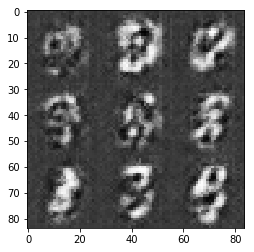

Epoch 1/2... Discriminator Loss: 1.1193... Generator Loss: 0.6102
Epoch 1/2... Discriminator Loss: 0.8408... Generator Loss: 1.0045
Epoch 1/2... Discriminator Loss: 0.7906... Generator Loss: 1.3615
Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 0.6001
Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 0.6537


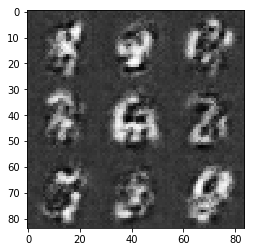

Epoch 1/2... Discriminator Loss: 1.0437... Generator Loss: 0.6568
Epoch 1/2... Discriminator Loss: 0.9667... Generator Loss: 1.1987
Epoch 1/2... Discriminator Loss: 0.8548... Generator Loss: 1.2415
Epoch 1/2... Discriminator Loss: 0.8858... Generator Loss: 0.9491
Epoch 1/2... Discriminator Loss: 1.2305... Generator Loss: 0.4588


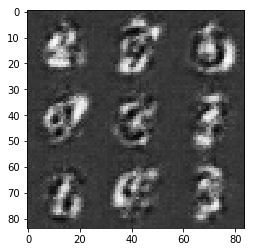

Epoch 1/2... Discriminator Loss: 0.9484... Generator Loss: 0.9866
Epoch 1/2... Discriminator Loss: 1.0340... Generator Loss: 0.8938
Epoch 1/2... Discriminator Loss: 1.1090... Generator Loss: 0.5948
Epoch 1/2... Discriminator Loss: 0.7626... Generator Loss: 1.1744
Epoch 1/2... Discriminator Loss: 0.9978... Generator Loss: 0.8362


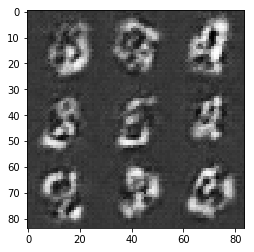

Epoch 1/2... Discriminator Loss: 0.9551... Generator Loss: 0.8756
Epoch 1/2... Discriminator Loss: 0.9453... Generator Loss: 0.7995
Epoch 1/2... Discriminator Loss: 0.9200... Generator Loss: 0.7379
Epoch 1/2... Discriminator Loss: 0.8495... Generator Loss: 1.0418
Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 0.7306


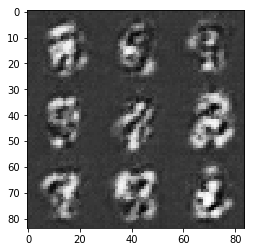

Epoch 1/2... Discriminator Loss: 0.8370... Generator Loss: 0.9916
Epoch 1/2... Discriminator Loss: 1.0100... Generator Loss: 0.6957
Epoch 1/2... Discriminator Loss: 0.9301... Generator Loss: 0.7762
Epoch 1/2... Discriminator Loss: 0.8174... Generator Loss: 1.0824
Epoch 1/2... Discriminator Loss: 0.7635... Generator Loss: 1.0783


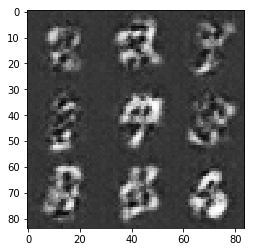

Epoch 1/2... Discriminator Loss: 0.7406... Generator Loss: 1.0727
Epoch 1/2... Discriminator Loss: 0.7927... Generator Loss: 1.1168
Epoch 1/2... Discriminator Loss: 0.8449... Generator Loss: 1.2297
Epoch 1/2... Discriminator Loss: 0.8253... Generator Loss: 0.8213
Epoch 1/2... Discriminator Loss: 0.7194... Generator Loss: 1.0164


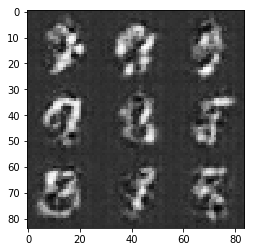

Epoch 1/2... Discriminator Loss: 0.8380... Generator Loss: 0.8562
Epoch 1/2... Discriminator Loss: 0.8480... Generator Loss: 1.1964
Epoch 1/2... Discriminator Loss: 0.8351... Generator Loss: 0.9472
Epoch 1/2... Discriminator Loss: 0.7242... Generator Loss: 1.0883
Epoch 1/2... Discriminator Loss: 0.7377... Generator Loss: 0.9908


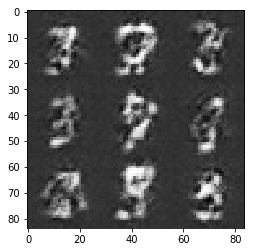

Epoch 1/2... Discriminator Loss: 0.7850... Generator Loss: 0.9957
Epoch 1/2... Discriminator Loss: 0.7173... Generator Loss: 1.0057
Epoch 1/2... Discriminator Loss: 0.7896... Generator Loss: 0.8706
Epoch 1/2... Discriminator Loss: 0.6239... Generator Loss: 1.4864
Epoch 1/2... Discriminator Loss: 0.7763... Generator Loss: 0.8858


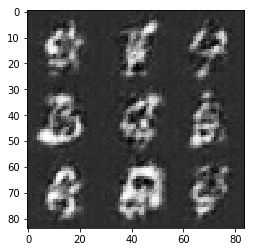

Epoch 1/2... Discriminator Loss: 0.7484... Generator Loss: 1.1448
Epoch 1/2... Discriminator Loss: 0.7702... Generator Loss: 0.9194
Epoch 1/2... Discriminator Loss: 1.1187... Generator Loss: 0.4944
Epoch 1/2... Discriminator Loss: 0.9111... Generator Loss: 0.6454
Epoch 1/2... Discriminator Loss: 1.1962... Generator Loss: 0.4234


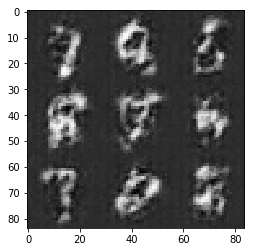

Epoch 1/2... Discriminator Loss: 0.8803... Generator Loss: 0.7453
Epoch 1/2... Discriminator Loss: 0.8015... Generator Loss: 0.9579
Epoch 1/2... Discriminator Loss: 0.8044... Generator Loss: 0.8292
Epoch 1/2... Discriminator Loss: 0.8921... Generator Loss: 0.6848
Epoch 1/2... Discriminator Loss: 0.6534... Generator Loss: 1.1480


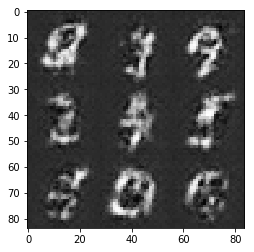

Epoch 1/2... Discriminator Loss: 0.5839... Generator Loss: 1.3301
Epoch 1/2... Discriminator Loss: 0.6831... Generator Loss: 1.0722
Epoch 1/2... Discriminator Loss: 0.6224... Generator Loss: 1.6574
Epoch 1/2... Discriminator Loss: 0.7016... Generator Loss: 0.9571
Epoch 1/2... Discriminator Loss: 0.6966... Generator Loss: 1.3241


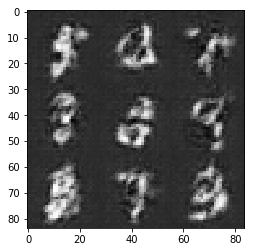

Epoch 1/2... Discriminator Loss: 0.7115... Generator Loss: 1.0944
Epoch 1/2... Discriminator Loss: 0.6229... Generator Loss: 1.2952
Epoch 1/2... Discriminator Loss: 0.7051... Generator Loss: 1.4136
Epoch 1/2... Discriminator Loss: 0.6935... Generator Loss: 1.0649
Epoch 1/2... Discriminator Loss: 0.9007... Generator Loss: 0.7421


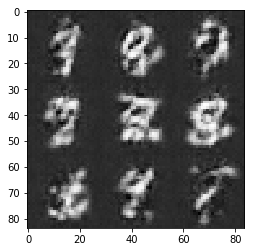

Epoch 1/2... Discriminator Loss: 0.9448... Generator Loss: 0.6425
Epoch 1/2... Discriminator Loss: 0.7440... Generator Loss: 0.9714
Epoch 1/2... Discriminator Loss: 0.8983... Generator Loss: 0.6932
Epoch 1/2... Discriminator Loss: 0.9978... Generator Loss: 0.6262
Epoch 1/2... Discriminator Loss: 0.6608... Generator Loss: 1.4615


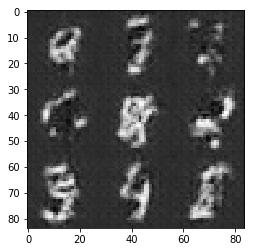

Epoch 1/2... Discriminator Loss: 0.8806... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 0.8175... Generator Loss: 0.8845
Epoch 1/2... Discriminator Loss: 0.8745... Generator Loss: 0.7519
Epoch 1/2... Discriminator Loss: 0.7554... Generator Loss: 1.3901
Epoch 1/2... Discriminator Loss: 0.9545... Generator Loss: 0.6516


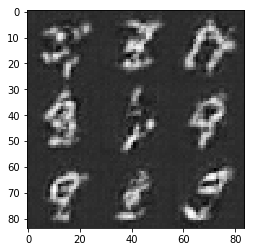

Epoch 1/2... Discriminator Loss: 0.8048... Generator Loss: 0.9755
Epoch 1/2... Discriminator Loss: 0.6365... Generator Loss: 1.3237
Epoch 1/2... Discriminator Loss: 0.7417... Generator Loss: 1.3529
Epoch 1/2... Discriminator Loss: 0.5974... Generator Loss: 1.4204
Epoch 1/2... Discriminator Loss: 0.6121... Generator Loss: 1.5060


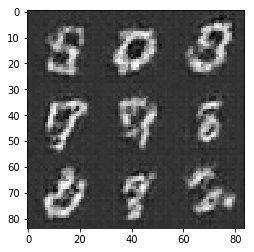

Epoch 1/2... Discriminator Loss: 0.7052... Generator Loss: 1.2438
Epoch 1/2... Discriminator Loss: 0.7764... Generator Loss: 0.8534
Epoch 1/2... Discriminator Loss: 0.7549... Generator Loss: 1.0636
Epoch 1/2... Discriminator Loss: 0.6735... Generator Loss: 1.3369
Epoch 1/2... Discriminator Loss: 1.1651... Generator Loss: 0.4721


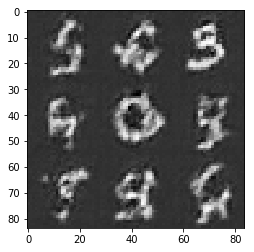

Epoch 1/2... Discriminator Loss: 1.2206... Generator Loss: 0.4428
Epoch 1/2... Discriminator Loss: 1.1909... Generator Loss: 0.4536
Epoch 1/2... Discriminator Loss: 0.5605... Generator Loss: 1.5020
Epoch 1/2... Discriminator Loss: 0.7257... Generator Loss: 1.0144
Epoch 1/2... Discriminator Loss: 0.7760... Generator Loss: 0.8892


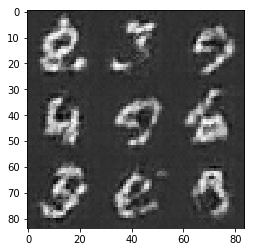

Epoch 1/2... Discriminator Loss: 0.9931... Generator Loss: 0.5725
Epoch 1/2... Discriminator Loss: 0.6843... Generator Loss: 1.2324
Epoch 1/2... Discriminator Loss: 0.5784... Generator Loss: 1.4861
Epoch 1/2... Discriminator Loss: 0.7183... Generator Loss: 1.0340
Epoch 1/2... Discriminator Loss: 0.6756... Generator Loss: 1.1345


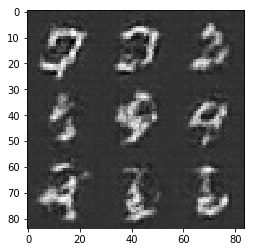

Epoch 1/2... Discriminator Loss: 0.7956... Generator Loss: 1.3780
Epoch 1/2... Discriminator Loss: 0.6277... Generator Loss: 1.5717
Epoch 1/2... Discriminator Loss: 1.0931... Generator Loss: 0.4989
Epoch 1/2... Discriminator Loss: 0.7940... Generator Loss: 0.9900
Epoch 1/2... Discriminator Loss: 0.7220... Generator Loss: 0.9290


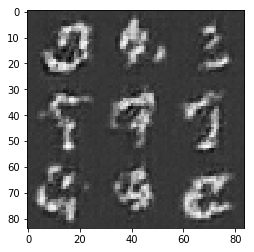

Epoch 1/2... Discriminator Loss: 0.8854... Generator Loss: 0.8072
Epoch 1/2... Discriminator Loss: 0.6224... Generator Loss: 1.3144
Epoch 1/2... Discriminator Loss: 0.8286... Generator Loss: 0.8684
Epoch 1/2... Discriminator Loss: 1.1087... Generator Loss: 0.5172
Epoch 1/2... Discriminator Loss: 0.9558... Generator Loss: 0.6222


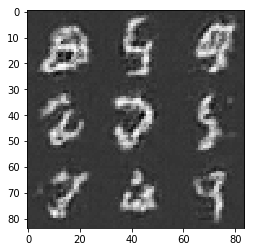

Epoch 1/2... Discriminator Loss: 0.7517... Generator Loss: 0.8829
Epoch 1/2... Discriminator Loss: 0.6495... Generator Loss: 1.2553
Epoch 1/2... Discriminator Loss: 0.7322... Generator Loss: 1.1729
Epoch 1/2... Discriminator Loss: 0.7630... Generator Loss: 0.8762
Epoch 1/2... Discriminator Loss: 0.8570... Generator Loss: 1.9748


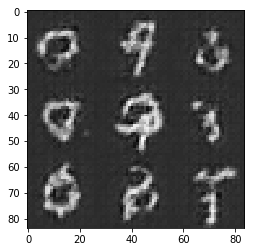

Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 0.4168
Epoch 1/2... Discriminator Loss: 0.8056... Generator Loss: 0.9922
Epoch 1/2... Discriminator Loss: 0.7481... Generator Loss: 0.9682
Epoch 1/2... Discriminator Loss: 1.2277... Generator Loss: 0.4184
Epoch 1/2... Discriminator Loss: 0.7501... Generator Loss: 1.0712


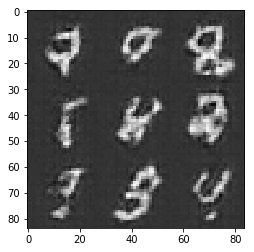

Epoch 1/2... Discriminator Loss: 0.5891... Generator Loss: 1.4220
Epoch 1/2... Discriminator Loss: 1.0915... Generator Loss: 0.5222
Epoch 1/2... Discriminator Loss: 1.1463... Generator Loss: 0.4945
Epoch 1/2... Discriminator Loss: 1.1245... Generator Loss: 0.5122
Epoch 1/2... Discriminator Loss: 0.9786... Generator Loss: 0.5918


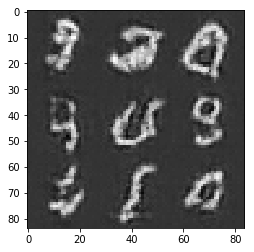

Epoch 1/2... Discriminator Loss: 1.0008... Generator Loss: 0.6392
Epoch 1/2... Discriminator Loss: 1.0404... Generator Loss: 0.5712
Epoch 1/2... Discriminator Loss: 0.6111... Generator Loss: 1.5518
Epoch 1/2... Discriminator Loss: 0.5292... Generator Loss: 1.5079
Epoch 1/2... Discriminator Loss: 0.5933... Generator Loss: 1.9122


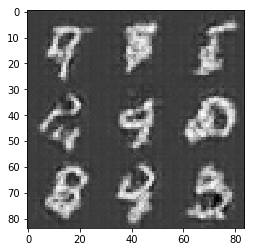

Epoch 1/2... Discriminator Loss: 0.8457... Generator Loss: 0.8131
Epoch 1/2... Discriminator Loss: 0.9321... Generator Loss: 0.6634
Epoch 1/2... Discriminator Loss: 0.9663... Generator Loss: 0.6284
Epoch 1/2... Discriminator Loss: 0.6304... Generator Loss: 1.5376
Epoch 1/2... Discriminator Loss: 0.7919... Generator Loss: 0.9442


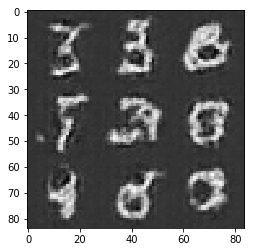

Epoch 1/2... Discriminator Loss: 0.5885... Generator Loss: 1.7557
Epoch 1/2... Discriminator Loss: 1.0257... Generator Loss: 0.5824
Epoch 1/2... Discriminator Loss: 0.7487... Generator Loss: 0.9408
Epoch 1/2... Discriminator Loss: 0.7144... Generator Loss: 0.9969
Epoch 1/2... Discriminator Loss: 0.9388... Generator Loss: 0.7162


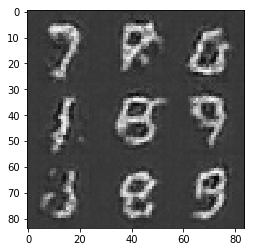

Epoch 1/2... Discriminator Loss: 0.7976... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 0.5299... Generator Loss: 2.0244
Epoch 1/2... Discriminator Loss: 0.7965... Generator Loss: 0.8804
Epoch 1/2... Discriminator Loss: 0.9280... Generator Loss: 0.7188
Epoch 1/2... Discriminator Loss: 0.9623... Generator Loss: 0.7022


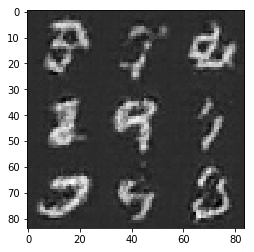

Epoch 1/2... Discriminator Loss: 0.7765... Generator Loss: 0.9229
Epoch 1/2... Discriminator Loss: 0.8415... Generator Loss: 0.7554
Epoch 1/2... Discriminator Loss: 1.0449... Generator Loss: 0.5618
Epoch 1/2... Discriminator Loss: 1.2026... Generator Loss: 0.4426
Epoch 1/2... Discriminator Loss: 0.5634... Generator Loss: 1.2527


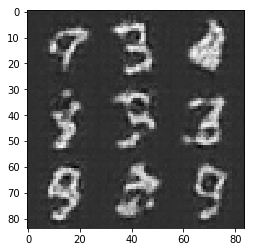

Epoch 1/2... Discriminator Loss: 0.9194... Generator Loss: 0.6447
Epoch 1/2... Discriminator Loss: 0.5334... Generator Loss: 1.4785
Epoch 2/2... Discriminator Loss: 0.5733... Generator Loss: 1.4570
Epoch 2/2... Discriminator Loss: 0.6576... Generator Loss: 1.1332
Epoch 2/2... Discriminator Loss: 0.8494... Generator Loss: 0.7317


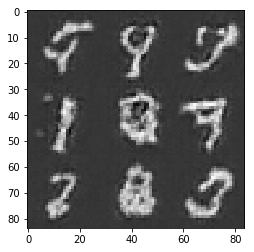

Epoch 2/2... Discriminator Loss: 1.0670... Generator Loss: 0.5814
Epoch 2/2... Discriminator Loss: 0.8459... Generator Loss: 1.6788
Epoch 2/2... Discriminator Loss: 0.9149... Generator Loss: 0.7429
Epoch 2/2... Discriminator Loss: 0.9139... Generator Loss: 0.7055
Epoch 2/2... Discriminator Loss: 0.9698... Generator Loss: 0.5856


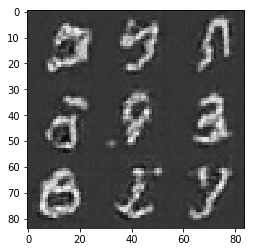

Epoch 2/2... Discriminator Loss: 0.4656... Generator Loss: 1.4732
Epoch 2/2... Discriminator Loss: 0.6864... Generator Loss: 1.2984
Epoch 2/2... Discriminator Loss: 0.9673... Generator Loss: 0.6360
Epoch 2/2... Discriminator Loss: 0.6698... Generator Loss: 2.0791
Epoch 2/2... Discriminator Loss: 0.7267... Generator Loss: 1.0064


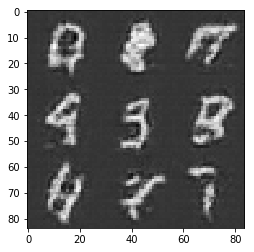

Epoch 2/2... Discriminator Loss: 0.6255... Generator Loss: 1.4373
Epoch 2/2... Discriminator Loss: 0.6791... Generator Loss: 1.4029
Epoch 2/2... Discriminator Loss: 0.3933... Generator Loss: 2.5134
Epoch 2/2... Discriminator Loss: 1.0532... Generator Loss: 0.5534
Epoch 2/2... Discriminator Loss: 0.9460... Generator Loss: 0.6542


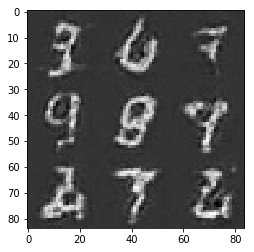

Epoch 2/2... Discriminator Loss: 1.1743... Generator Loss: 0.4576
Epoch 2/2... Discriminator Loss: 0.7935... Generator Loss: 0.8651
Epoch 2/2... Discriminator Loss: 0.5727... Generator Loss: 1.2807
Epoch 2/2... Discriminator Loss: 0.6878... Generator Loss: 1.0215
Epoch 2/2... Discriminator Loss: 0.9665... Generator Loss: 0.6110


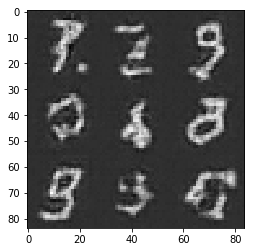

Epoch 2/2... Discriminator Loss: 0.5563... Generator Loss: 1.3513
Epoch 2/2... Discriminator Loss: 0.7723... Generator Loss: 2.0546
Epoch 2/2... Discriminator Loss: 0.7080... Generator Loss: 1.2831
Epoch 2/2... Discriminator Loss: 0.7241... Generator Loss: 0.8749
Epoch 2/2... Discriminator Loss: 0.9951... Generator Loss: 0.5972


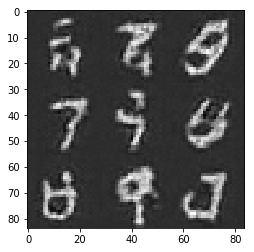

Epoch 2/2... Discriminator Loss: 0.7353... Generator Loss: 1.4251
Epoch 2/2... Discriminator Loss: 0.6640... Generator Loss: 1.0690
Epoch 2/2... Discriminator Loss: 0.6074... Generator Loss: 1.1474
Epoch 2/2... Discriminator Loss: 0.9250... Generator Loss: 0.6468
Epoch 2/2... Discriminator Loss: 0.9049... Generator Loss: 0.7303


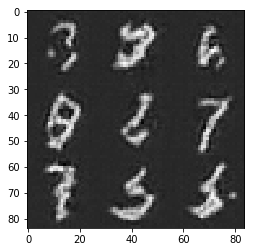

Epoch 2/2... Discriminator Loss: 1.2231... Generator Loss: 0.4630
Epoch 2/2... Discriminator Loss: 0.4918... Generator Loss: 1.7812
Epoch 2/2... Discriminator Loss: 0.6171... Generator Loss: 1.1383
Epoch 2/2... Discriminator Loss: 0.6145... Generator Loss: 1.1461
Epoch 2/2... Discriminator Loss: 0.7894... Generator Loss: 0.8331


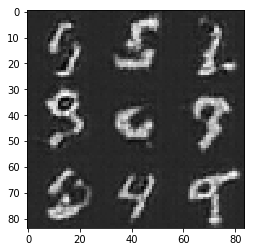

Epoch 2/2... Discriminator Loss: 1.2151... Generator Loss: 0.4431
Epoch 2/2... Discriminator Loss: 0.6382... Generator Loss: 1.0072
Epoch 2/2... Discriminator Loss: 0.6573... Generator Loss: 1.5314
Epoch 2/2... Discriminator Loss: 0.4940... Generator Loss: 1.3886
Epoch 2/2... Discriminator Loss: 0.8493... Generator Loss: 0.7911


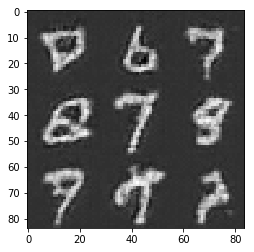

Epoch 2/2... Discriminator Loss: 0.4483... Generator Loss: 1.9070
Epoch 2/2... Discriminator Loss: 0.5202... Generator Loss: 1.8646
Epoch 2/2... Discriminator Loss: 0.6434... Generator Loss: 1.0404
Epoch 2/2... Discriminator Loss: 0.6954... Generator Loss: 1.0250
Epoch 2/2... Discriminator Loss: 0.6766... Generator Loss: 0.9723


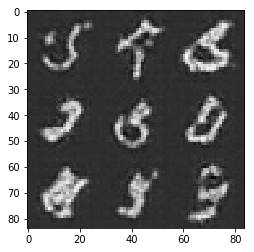

Epoch 2/2... Discriminator Loss: 1.1737... Generator Loss: 0.4666
Epoch 2/2... Discriminator Loss: 0.7672... Generator Loss: 0.9491
Epoch 2/2... Discriminator Loss: 1.0980... Generator Loss: 0.5092
Epoch 2/2... Discriminator Loss: 0.7065... Generator Loss: 1.0206
Epoch 2/2... Discriminator Loss: 0.7771... Generator Loss: 0.7973


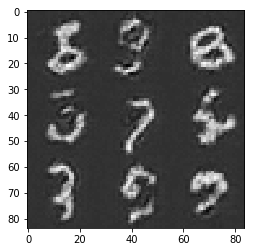

Epoch 2/2... Discriminator Loss: 0.6052... Generator Loss: 1.6080
Epoch 2/2... Discriminator Loss: 0.5316... Generator Loss: 1.4347
Epoch 2/2... Discriminator Loss: 0.6788... Generator Loss: 1.7027
Epoch 2/2... Discriminator Loss: 1.0097... Generator Loss: 0.5710
Epoch 2/2... Discriminator Loss: 0.6763... Generator Loss: 1.1956


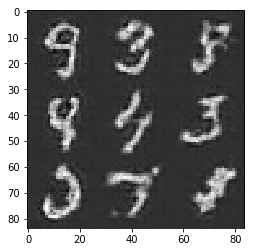

Epoch 2/2... Discriminator Loss: 0.7596... Generator Loss: 0.9173
Epoch 2/2... Discriminator Loss: 0.6301... Generator Loss: 1.0038
Epoch 2/2... Discriminator Loss: 0.5956... Generator Loss: 1.5468
Epoch 2/2... Discriminator Loss: 0.6303... Generator Loss: 1.3113
Epoch 2/2... Discriminator Loss: 0.9766... Generator Loss: 0.6659


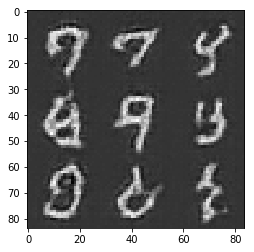

Epoch 2/2... Discriminator Loss: 1.1482... Generator Loss: 0.4976
Epoch 2/2... Discriminator Loss: 0.8990... Generator Loss: 0.6617
Epoch 2/2... Discriminator Loss: 1.0480... Generator Loss: 0.5580
Epoch 2/2... Discriminator Loss: 0.9869... Generator Loss: 0.5971
Epoch 2/2... Discriminator Loss: 1.0327... Generator Loss: 0.5351


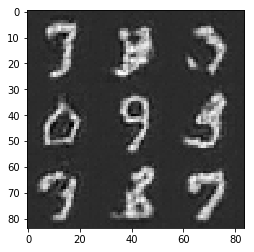

Epoch 2/2... Discriminator Loss: 0.5215... Generator Loss: 2.1872
Epoch 2/2... Discriminator Loss: 1.1895... Generator Loss: 0.4415
Epoch 2/2... Discriminator Loss: 0.4369... Generator Loss: 1.7091
Epoch 2/2... Discriminator Loss: 0.8077... Generator Loss: 1.2832
Epoch 2/2... Discriminator Loss: 0.5982... Generator Loss: 1.2878


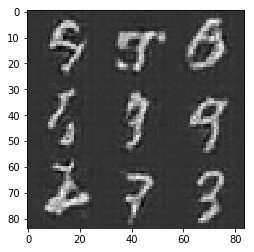

Epoch 2/2... Discriminator Loss: 1.1954... Generator Loss: 0.4733
Epoch 2/2... Discriminator Loss: 0.4658... Generator Loss: 1.4810
Epoch 2/2... Discriminator Loss: 0.8438... Generator Loss: 2.4943
Epoch 2/2... Discriminator Loss: 0.7038... Generator Loss: 1.8857
Epoch 2/2... Discriminator Loss: 0.6403... Generator Loss: 2.1231


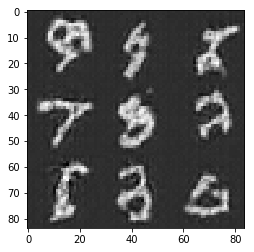

Epoch 2/2... Discriminator Loss: 1.1439... Generator Loss: 0.4584
Epoch 2/2... Discriminator Loss: 1.1795... Generator Loss: 0.4552
Epoch 2/2... Discriminator Loss: 0.7216... Generator Loss: 0.9900
Epoch 2/2... Discriminator Loss: 1.0984... Generator Loss: 0.5187
Epoch 2/2... Discriminator Loss: 0.6481... Generator Loss: 1.1917


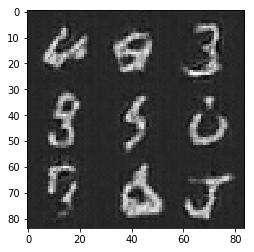

Epoch 2/2... Discriminator Loss: 0.8747... Generator Loss: 0.7000
Epoch 2/2... Discriminator Loss: 0.7445... Generator Loss: 0.9157
Epoch 2/2... Discriminator Loss: 0.8667... Generator Loss: 0.7755
Epoch 2/2... Discriminator Loss: 0.8196... Generator Loss: 0.8100
Epoch 2/2... Discriminator Loss: 0.6493... Generator Loss: 1.0212


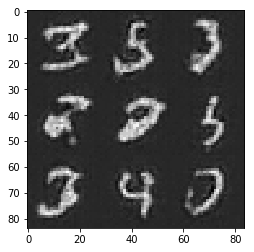

Epoch 2/2... Discriminator Loss: 0.4235... Generator Loss: 1.8963
Epoch 2/2... Discriminator Loss: 0.6417... Generator Loss: 1.0163
Epoch 2/2... Discriminator Loss: 0.6427... Generator Loss: 1.0310
Epoch 2/2... Discriminator Loss: 1.1623... Generator Loss: 0.4825
Epoch 2/2... Discriminator Loss: 0.6223... Generator Loss: 1.1952


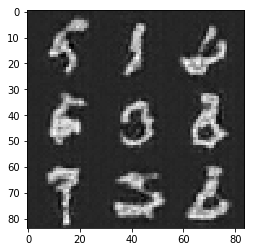

Epoch 2/2... Discriminator Loss: 0.6763... Generator Loss: 0.9273
Epoch 2/2... Discriminator Loss: 1.0877... Generator Loss: 0.5107
Epoch 2/2... Discriminator Loss: 0.3658... Generator Loss: 2.6402
Epoch 2/2... Discriminator Loss: 0.5499... Generator Loss: 1.4002
Epoch 2/2... Discriminator Loss: 0.7696... Generator Loss: 2.8216


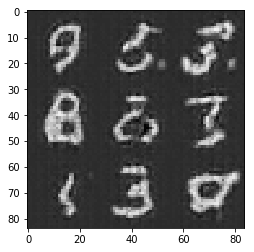

Epoch 2/2... Discriminator Loss: 0.6551... Generator Loss: 1.0967
Epoch 2/2... Discriminator Loss: 0.9012... Generator Loss: 0.7034
Epoch 2/2... Discriminator Loss: 0.5291... Generator Loss: 1.1814
Epoch 2/2... Discriminator Loss: 0.5858... Generator Loss: 1.3096
Epoch 2/2... Discriminator Loss: 1.1198... Generator Loss: 0.5124


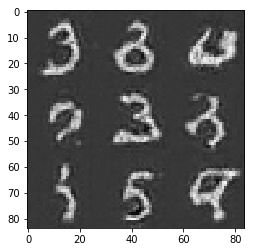

Epoch 2/2... Discriminator Loss: 0.5164... Generator Loss: 1.2567
Epoch 2/2... Discriminator Loss: 0.4629... Generator Loss: 1.6267
Epoch 2/2... Discriminator Loss: 0.5835... Generator Loss: 1.4501
Epoch 2/2... Discriminator Loss: 0.9709... Generator Loss: 0.6320
Epoch 2/2... Discriminator Loss: 0.9300... Generator Loss: 0.7186


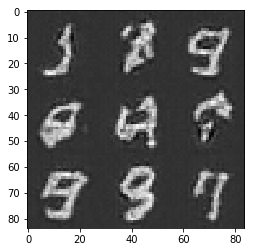

Epoch 2/2... Discriminator Loss: 0.6783... Generator Loss: 0.9877
Epoch 2/2... Discriminator Loss: 0.4301... Generator Loss: 2.4454
Epoch 2/2... Discriminator Loss: 0.5710... Generator Loss: 1.2717
Epoch 2/2... Discriminator Loss: 0.3958... Generator Loss: 1.7344
Epoch 2/2... Discriminator Loss: 0.8528... Generator Loss: 0.6846


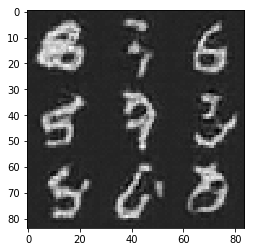

Epoch 2/2... Discriminator Loss: 0.6634... Generator Loss: 1.1381
Epoch 2/2... Discriminator Loss: 0.6584... Generator Loss: 0.9774
Epoch 2/2... Discriminator Loss: 0.7182... Generator Loss: 0.9796
Epoch 2/2... Discriminator Loss: 0.7033... Generator Loss: 0.9085
Epoch 2/2... Discriminator Loss: 0.5753... Generator Loss: 1.5137


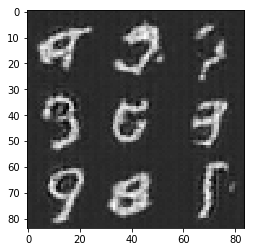

Epoch 2/2... Discriminator Loss: 0.5057... Generator Loss: 1.2719
Epoch 2/2... Discriminator Loss: 0.6680... Generator Loss: 1.1267
Epoch 2/2... Discriminator Loss: 0.4118... Generator Loss: 1.8432
Epoch 2/2... Discriminator Loss: 0.7335... Generator Loss: 0.8775
Epoch 2/2... Discriminator Loss: 1.1039... Generator Loss: 0.5143


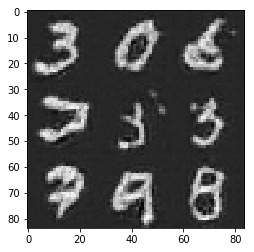

Epoch 2/2... Discriminator Loss: 0.5639... Generator Loss: 1.2183
Epoch 2/2... Discriminator Loss: 0.7027... Generator Loss: 1.0668
Epoch 2/2... Discriminator Loss: 0.5860... Generator Loss: 1.2612
Epoch 2/2... Discriminator Loss: 0.4615... Generator Loss: 1.6140
Epoch 2/2... Discriminator Loss: 0.7781... Generator Loss: 0.7857


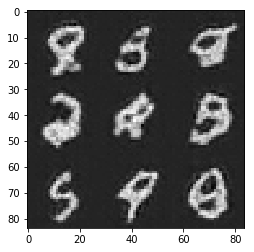

Epoch 2/2... Discriminator Loss: 0.6082... Generator Loss: 1.1761
Epoch 2/2... Discriminator Loss: 0.3927... Generator Loss: 2.1512
Epoch 2/2... Discriminator Loss: 0.5466... Generator Loss: 1.4508
Epoch 2/2... Discriminator Loss: 0.4233... Generator Loss: 1.5982
Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 0.5128


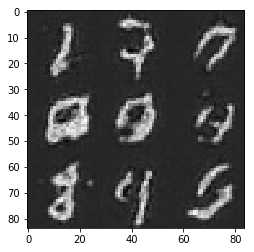

Epoch 2/2... Discriminator Loss: 0.5478... Generator Loss: 1.8393
Epoch 2/2... Discriminator Loss: 0.5280... Generator Loss: 2.7012
Epoch 2/2... Discriminator Loss: 0.5843... Generator Loss: 1.3889
Epoch 2/2... Discriminator Loss: 0.7417... Generator Loss: 1.1550
Epoch 2/2... Discriminator Loss: 1.2964... Generator Loss: 0.4427


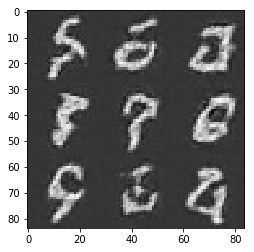

Epoch 2/2... Discriminator Loss: 0.5671... Generator Loss: 2.7982
Epoch 2/2... Discriminator Loss: 0.6143... Generator Loss: 1.0602
Epoch 2/2... Discriminator Loss: 0.6314... Generator Loss: 1.1061
Epoch 2/2... Discriminator Loss: 1.1472... Generator Loss: 0.5530
Epoch 2/2... Discriminator Loss: 0.6194... Generator Loss: 1.1083


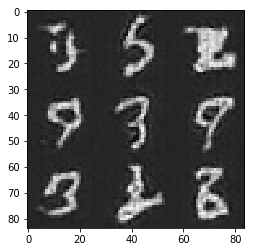

Epoch 2/2... Discriminator Loss: 1.1052... Generator Loss: 0.5253
Epoch 2/2... Discriminator Loss: 0.4759... Generator Loss: 1.6490
Epoch 2/2... Discriminator Loss: 0.7599... Generator Loss: 0.8766
Epoch 2/2... Discriminator Loss: 0.4101... Generator Loss: 1.5724
Epoch 2/2... Discriminator Loss: 0.7375... Generator Loss: 1.0372


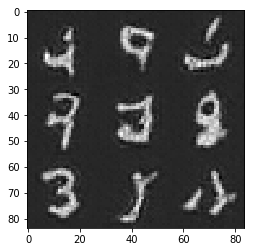

Epoch 2/2... Discriminator Loss: 0.7574... Generator Loss: 0.8618
Epoch 2/2... Discriminator Loss: 0.5356... Generator Loss: 1.1996
Epoch 2/2... Discriminator Loss: 0.5984... Generator Loss: 1.1051
Epoch 2/2... Discriminator Loss: 0.8979... Generator Loss: 0.7140
Epoch 2/2... Discriminator Loss: 0.4656... Generator Loss: 1.6099


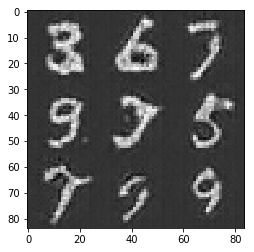

Epoch 2/2... Discriminator Loss: 0.5152... Generator Loss: 1.2706
Epoch 2/2... Discriminator Loss: 0.9295... Generator Loss: 0.6803
Epoch 2/2... Discriminator Loss: 0.8484... Generator Loss: 0.7719
Epoch 2/2... Discriminator Loss: 0.4669... Generator Loss: 1.5547
Epoch 2/2... Discriminator Loss: 0.8525... Generator Loss: 0.7186


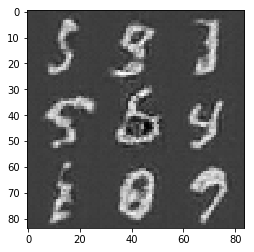

Epoch 2/2... Discriminator Loss: 0.4554... Generator Loss: 1.9648
Epoch 2/2... Discriminator Loss: 0.6409... Generator Loss: 1.0600
Epoch 2/2... Discriminator Loss: 0.6212... Generator Loss: 1.5392
Epoch 2/2... Discriminator Loss: 0.9623... Generator Loss: 0.6601
Epoch 2/2... Discriminator Loss: 0.7973... Generator Loss: 0.8133


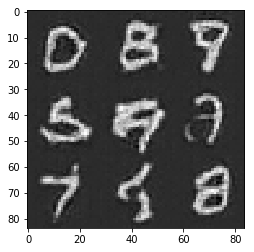

Epoch 2/2... Discriminator Loss: 1.0551... Generator Loss: 0.5326
Epoch 2/2... Discriminator Loss: 0.3380... Generator Loss: 2.2342
Epoch 2/2... Discriminator Loss: 0.5520... Generator Loss: 1.7530
Epoch 2/2... Discriminator Loss: 0.4979... Generator Loss: 1.3663
Epoch 2/2... Discriminator Loss: 0.6268... Generator Loss: 1.1780


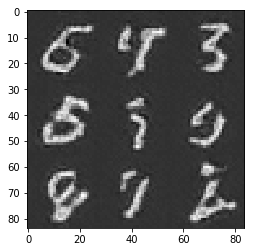

Epoch 2/2... Discriminator Loss: 0.5772... Generator Loss: 1.1289
Epoch 2/2... Discriminator Loss: 0.5783... Generator Loss: 2.6638
Epoch 2/2... Discriminator Loss: 0.8110... Generator Loss: 0.8729
Epoch 2/2... Discriminator Loss: 0.5288... Generator Loss: 1.7076
Epoch 2/2... Discriminator Loss: 1.1010... Generator Loss: 0.5113


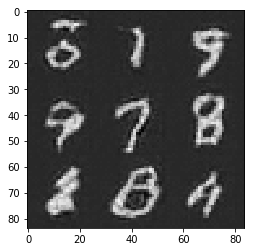

Epoch 2/2... Discriminator Loss: 0.5811... Generator Loss: 1.1655
Epoch 2/2... Discriminator Loss: 0.4732... Generator Loss: 1.4359
Epoch 2/2... Discriminator Loss: 0.5626... Generator Loss: 1.1253
Epoch 2/2... Discriminator Loss: 0.6963... Generator Loss: 1.0749
Epoch 2/2... Discriminator Loss: 0.5501... Generator Loss: 1.8148


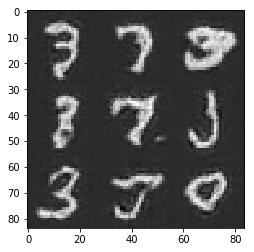

Epoch 2/2... Discriminator Loss: 0.7628... Generator Loss: 0.8721
Epoch 2/2... Discriminator Loss: 0.6235... Generator Loss: 1.0304
Epoch 2/2... Discriminator Loss: 1.3015... Generator Loss: 0.3892
Epoch 2/2... Discriminator Loss: 0.4745... Generator Loss: 2.7973
Epoch 2/2... Discriminator Loss: 1.1444... Generator Loss: 0.4802


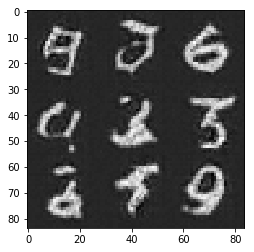

Epoch 2/2... Discriminator Loss: 0.5487... Generator Loss: 1.5264
Epoch 2/2... Discriminator Loss: 0.5768... Generator Loss: 1.1308
Epoch 2/2... Discriminator Loss: 1.0307... Generator Loss: 0.5984
Epoch 2/2... Discriminator Loss: 0.9665... Generator Loss: 0.6362
Epoch 2/2... Discriminator Loss: 0.4818... Generator Loss: 1.7534


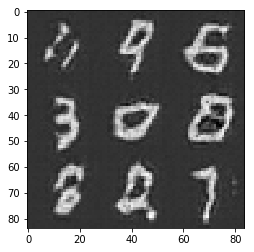

In [42]:
batch_size = 32
z_dim = 200
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.7563... Generator Loss: 0.0133
Epoch 1/1... Discriminator Loss: 4.5441... Generator Loss: 0.0179
Epoch 1/1... Discriminator Loss: 4.3013... Generator Loss: 0.0290
Epoch 1/1... Discriminator Loss: 3.7731... Generator Loss: 0.0394
Epoch 1/1... Discriminator Loss: 3.4300... Generator Loss: 0.0611


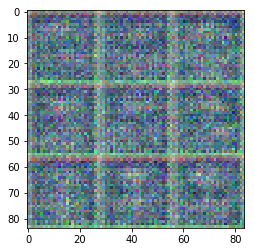

Epoch 1/1... Discriminator Loss: 3.1241... Generator Loss: 0.1065
Epoch 1/1... Discriminator Loss: 2.8283... Generator Loss: 0.1891
Epoch 1/1... Discriminator Loss: 2.1326... Generator Loss: 0.2793
Epoch 1/1... Discriminator Loss: 1.8604... Generator Loss: 0.3806
Epoch 1/1... Discriminator Loss: 1.7038... Generator Loss: 0.4490


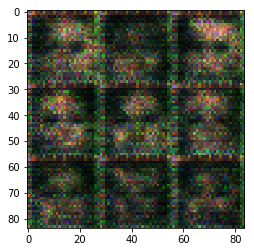

Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.5292... Generator Loss: 0.3888
Epoch 1/1... Discriminator Loss: 1.7201... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.2500... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.0787... Generator Loss: 1.0119


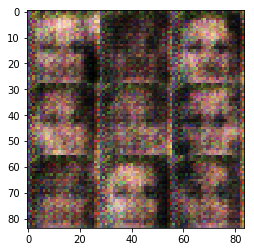

Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 2.7892
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.6687... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.1836... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.8436... Generator Loss: 0.3615


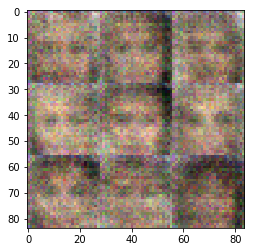

Epoch 1/1... Discriminator Loss: 1.8174... Generator Loss: 0.4429
Epoch 1/1... Discriminator Loss: 0.7100... Generator Loss: 2.2839
Epoch 1/1... Discriminator Loss: 1.7711... Generator Loss: 0.3804
Epoch 1/1... Discriminator Loss: 1.8234... Generator Loss: 0.3754
Epoch 1/1... Discriminator Loss: 1.7058... Generator Loss: 0.4505


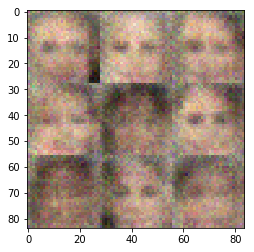

Epoch 1/1... Discriminator Loss: 1.5465... Generator Loss: 0.5173
Epoch 1/1... Discriminator Loss: 1.6887... Generator Loss: 0.3526
Epoch 1/1... Discriminator Loss: 1.6711... Generator Loss: 0.5039
Epoch 1/1... Discriminator Loss: 1.5509... Generator Loss: 0.4600
Epoch 1/1... Discriminator Loss: 1.5715... Generator Loss: 0.4891


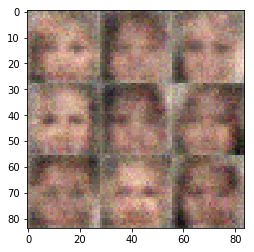

Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 1.0265
Epoch 1/1... Discriminator Loss: 1.6796... Generator Loss: 0.4608
Epoch 1/1... Discriminator Loss: 1.7849... Generator Loss: 0.4647
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.8284


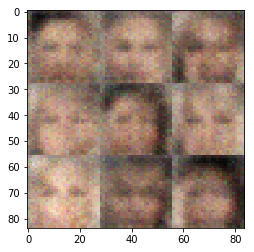

Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.6025... Generator Loss: 0.5050
Epoch 1/1... Discriminator Loss: 1.7301... Generator Loss: 0.4995
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.9273
Epoch 1/1... Discriminator Loss: 1.5673... Generator Loss: 0.5645


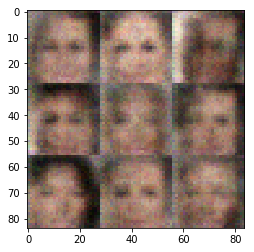

Epoch 1/1... Discriminator Loss: 1.5834... Generator Loss: 0.5895
Epoch 1/1... Discriminator Loss: 1.7191... Generator Loss: 0.4643
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.7172... Generator Loss: 0.3809
Epoch 1/1... Discriminator Loss: 1.6559... Generator Loss: 0.6184


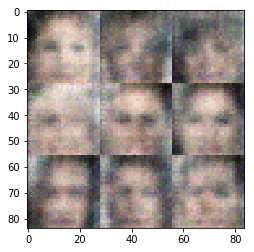

Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 0.8956... Generator Loss: 1.6054
Epoch 1/1... Discriminator Loss: 0.8108... Generator Loss: 2.0363
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.7342... Generator Loss: 0.3723


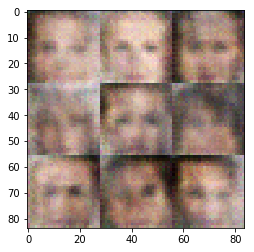

Epoch 1/1... Discriminator Loss: 0.8923... Generator Loss: 1.9900
Epoch 1/1... Discriminator Loss: 0.9327... Generator Loss: 1.2334
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.6919... Generator Loss: 0.3930


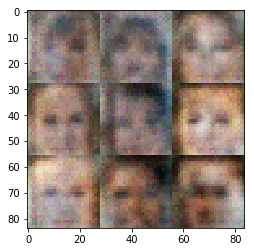

Epoch 1/1... Discriminator Loss: 1.8958... Generator Loss: 0.2409
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.5051
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 1.4067
Epoch 1/1... Discriminator Loss: 1.2779... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.6707... Generator Loss: 0.3373


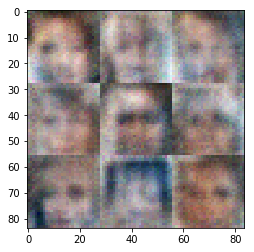

Epoch 1/1... Discriminator Loss: 1.3332... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 0.7072... Generator Loss: 3.8667
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.0124... Generator Loss: 0.9905
Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 2.6069


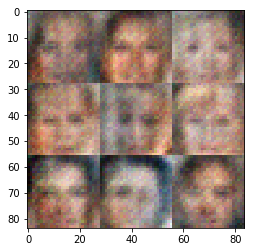

Epoch 1/1... Discriminator Loss: 0.9053... Generator Loss: 2.8785
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.4935
Epoch 1/1... Discriminator Loss: 1.7289... Generator Loss: 0.3007
Epoch 1/1... Discriminator Loss: 1.7353... Generator Loss: 0.3219
Epoch 1/1... Discriminator Loss: 1.4794... Generator Loss: 0.4629


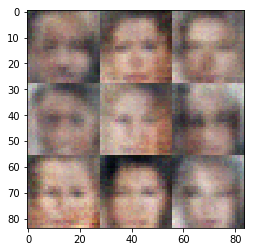

Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.6044
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 1.8172
Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 3.5124
Epoch 1/1... Discriminator Loss: 1.9706... Generator Loss: 0.2396
Epoch 1/1... Discriminator Loss: 0.9721... Generator Loss: 0.8531


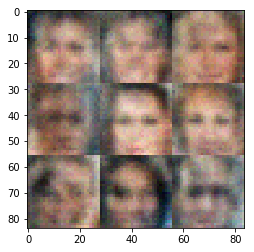

Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 0.8137... Generator Loss: 3.7413
Epoch 1/1... Discriminator Loss: 1.8322... Generator Loss: 0.2700
Epoch 1/1... Discriminator Loss: 1.6872... Generator Loss: 0.3023
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.7022


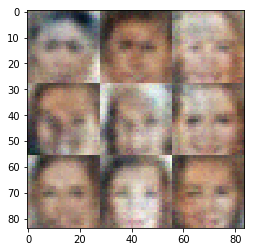

Epoch 1/1... Discriminator Loss: 0.6140... Generator Loss: 3.5953
Epoch 1/1... Discriminator Loss: 1.6692... Generator Loss: 0.3269
Epoch 1/1... Discriminator Loss: 1.5793... Generator Loss: 0.3942
Epoch 1/1... Discriminator Loss: 1.8223... Generator Loss: 0.2750
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.6973


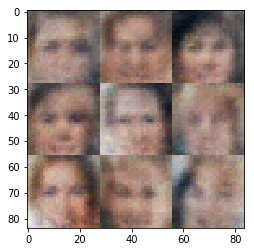

Epoch 1/1... Discriminator Loss: 0.8949... Generator Loss: 1.1101
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.1649... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.6319
Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 2.2211


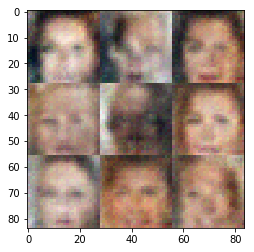

Epoch 1/1... Discriminator Loss: 0.7330... Generator Loss: 2.8567
Epoch 1/1... Discriminator Loss: 0.7186... Generator Loss: 5.5067
Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 1.3543
Epoch 1/1... Discriminator Loss: 1.7561... Generator Loss: 0.2860
Epoch 1/1... Discriminator Loss: 0.8973... Generator Loss: 1.9398


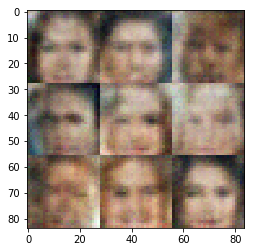

Epoch 1/1... Discriminator Loss: 0.7615... Generator Loss: 2.5439
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 0.6734... Generator Loss: 3.1637
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.5769
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.6260


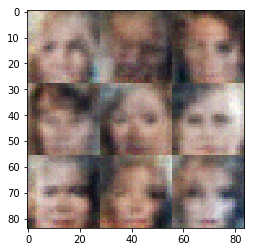

Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.5177
Epoch 1/1... Discriminator Loss: 0.7452... Generator Loss: 1.5460
Epoch 1/1... Discriminator Loss: 0.7204... Generator Loss: 1.2748
Epoch 1/1... Discriminator Loss: 1.8179... Generator Loss: 0.2543
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.5514


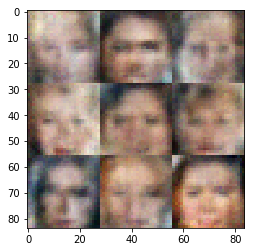

Epoch 1/1... Discriminator Loss: 1.5522... Generator Loss: 0.4098
Epoch 1/1... Discriminator Loss: 2.0949... Generator Loss: 0.1683
Epoch 1/1... Discriminator Loss: 0.9190... Generator Loss: 0.8560
Epoch 1/1... Discriminator Loss: 1.0269... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 1.6777... Generator Loss: 0.3235


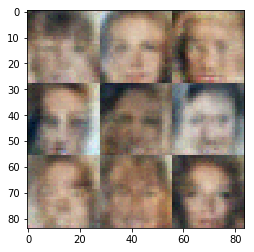

Epoch 1/1... Discriminator Loss: 1.6683... Generator Loss: 0.3002
Epoch 1/1... Discriminator Loss: 0.6018... Generator Loss: 4.5909
Epoch 1/1... Discriminator Loss: 1.5626... Generator Loss: 0.3686
Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 0.7004... Generator Loss: 3.1680


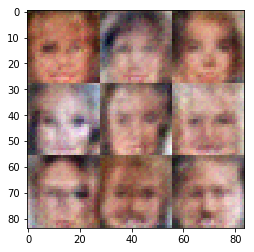

Epoch 1/1... Discriminator Loss: 0.4305... Generator Loss: 3.9423
Epoch 1/1... Discriminator Loss: 0.7512... Generator Loss: 1.1322
Epoch 1/1... Discriminator Loss: 0.8857... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 1.7912
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.7677


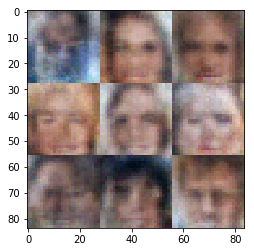

Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.5304
Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 1.5732
Epoch 1/1... Discriminator Loss: 0.6029... Generator Loss: 4.9149
Epoch 1/1... Discriminator Loss: 0.9932... Generator Loss: 1.0483


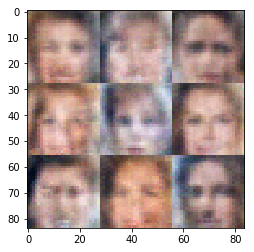

Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 0.8877
Epoch 1/1... Discriminator Loss: 1.4472... Generator Loss: 0.4798
Epoch 1/1... Discriminator Loss: 0.4888... Generator Loss: 2.0375
Epoch 1/1... Discriminator Loss: 0.5144... Generator Loss: 4.1928
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 1.2689


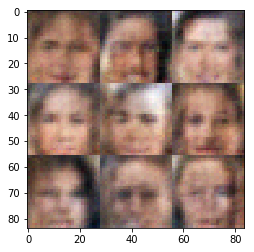

Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.5151
Epoch 1/1... Discriminator Loss: 0.6291... Generator Loss: 2.8312
Epoch 1/1... Discriminator Loss: 0.6810... Generator Loss: 3.7271
Epoch 1/1... Discriminator Loss: 0.4754... Generator Loss: 1.8910
Epoch 1/1... Discriminator Loss: 0.5709... Generator Loss: 1.2182


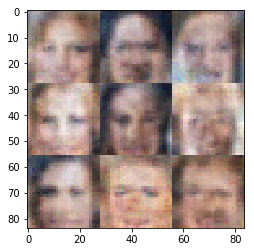

Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.5041
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.3301
Epoch 1/1... Discriminator Loss: 0.7697... Generator Loss: 5.5416
Epoch 1/1... Discriminator Loss: 0.8406... Generator Loss: 2.2454


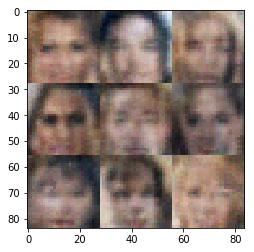

Epoch 1/1... Discriminator Loss: 0.6922... Generator Loss: 4.6975
Epoch 1/1... Discriminator Loss: 0.7934... Generator Loss: 2.0912
Epoch 1/1... Discriminator Loss: 0.5388... Generator Loss: 5.4931
Epoch 1/1... Discriminator Loss: 0.4308... Generator Loss: 3.5714
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.5209


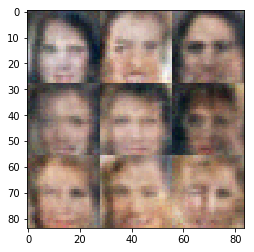

Epoch 1/1... Discriminator Loss: 0.6366... Generator Loss: 2.1327
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.4761
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.4425
Epoch 1/1... Discriminator Loss: 0.6052... Generator Loss: 3.9732
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.5935


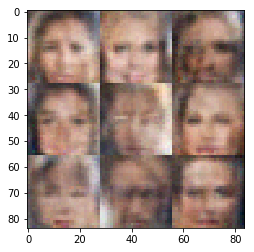

Epoch 1/1... Discriminator Loss: 0.8196... Generator Loss: 3.2542
Epoch 1/1... Discriminator Loss: 0.7317... Generator Loss: 3.6131
Epoch 1/1... Discriminator Loss: 0.7626... Generator Loss: 3.3272
Epoch 1/1... Discriminator Loss: 0.7474... Generator Loss: 3.2222
Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 0.9639


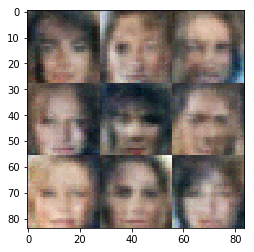

Epoch 1/1... Discriminator Loss: 0.8110... Generator Loss: 1.1304
Epoch 1/1... Discriminator Loss: 1.6482... Generator Loss: 0.3370
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 0.7303... Generator Loss: 5.4423
Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 4.2876


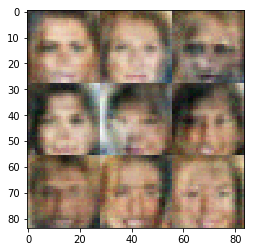

Epoch 1/1... Discriminator Loss: 0.8670... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.3726
Epoch 1/1... Discriminator Loss: 1.0589... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.6716... Generator Loss: 0.3503
Epoch 1/1... Discriminator Loss: 1.7992... Generator Loss: 0.2834


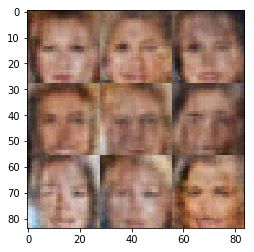

Epoch 1/1... Discriminator Loss: 1.0714... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 0.7768... Generator Loss: 2.8592
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 0.7093... Generator Loss: 3.6047
Epoch 1/1... Discriminator Loss: 0.9189... Generator Loss: 1.2094


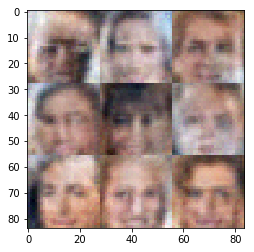

Epoch 1/1... Discriminator Loss: 1.7187... Generator Loss: 0.3191
Epoch 1/1... Discriminator Loss: 0.8763... Generator Loss: 1.6389
Epoch 1/1... Discriminator Loss: 1.6419... Generator Loss: 0.3292
Epoch 1/1... Discriminator Loss: 1.5765... Generator Loss: 0.4005
Epoch 1/1... Discriminator Loss: 0.7847... Generator Loss: 3.4290


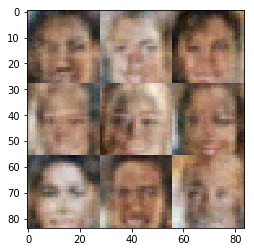

Epoch 1/1... Discriminator Loss: 0.6757... Generator Loss: 1.6284
Epoch 1/1... Discriminator Loss: 1.8111... Generator Loss: 0.2759
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.4093
Epoch 1/1... Discriminator Loss: 1.5989... Generator Loss: 0.4549
Epoch 1/1... Discriminator Loss: 1.4435... Generator Loss: 0.4591


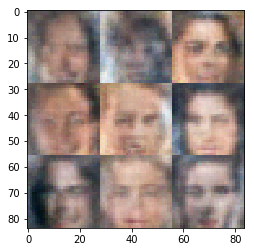

Epoch 1/1... Discriminator Loss: 0.8731... Generator Loss: 1.5201
Epoch 1/1... Discriminator Loss: 0.9215... Generator Loss: 1.9513
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 1.7490
Epoch 1/1... Discriminator Loss: 0.6195... Generator Loss: 1.7694


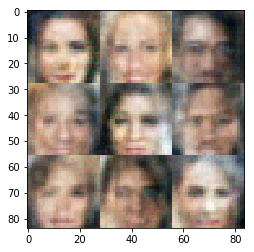

Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 3.0562
Epoch 1/1... Discriminator Loss: 1.7064... Generator Loss: 0.3282
Epoch 1/1... Discriminator Loss: 1.0311... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 0.6440... Generator Loss: 2.6691
Epoch 1/1... Discriminator Loss: 0.7588... Generator Loss: 3.2005


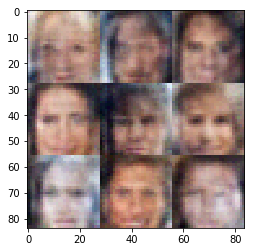

Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.4527
Epoch 1/1... Discriminator Loss: 0.7006... Generator Loss: 1.8821
Epoch 1/1... Discriminator Loss: 0.5453... Generator Loss: 2.8998
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.2085
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.4213


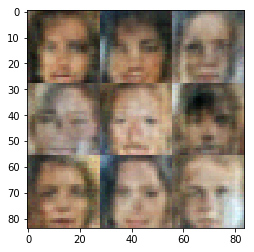

Epoch 1/1... Discriminator Loss: 0.6484... Generator Loss: 3.5434
Epoch 1/1... Discriminator Loss: 1.5940... Generator Loss: 0.3540
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 1.1007
Epoch 1/1... Discriminator Loss: 1.6009... Generator Loss: 0.3914
Epoch 1/1... Discriminator Loss: 1.0098... Generator Loss: 1.1317


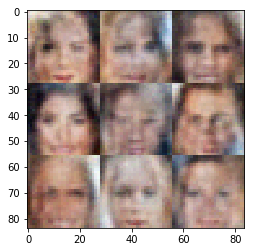

Epoch 1/1... Discriminator Loss: 1.5679... Generator Loss: 0.3710
Epoch 1/1... Discriminator Loss: 1.7501... Generator Loss: 0.3008
Epoch 1/1... Discriminator Loss: 0.7471... Generator Loss: 1.4350
Epoch 1/1... Discriminator Loss: 1.6331... Generator Loss: 0.3461
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 2.4762


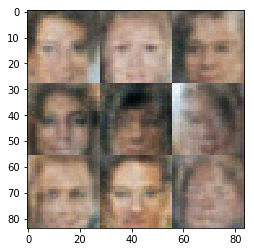

Epoch 1/1... Discriminator Loss: 1.6909... Generator Loss: 0.3031
Epoch 1/1... Discriminator Loss: 0.7041... Generator Loss: 3.0925
Epoch 1/1... Discriminator Loss: 1.4808... Generator Loss: 0.3811
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 0.6385... Generator Loss: 1.6698


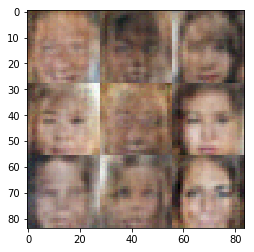

Epoch 1/1... Discriminator Loss: 1.5550... Generator Loss: 0.4302
Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 1.6702
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 0.7704... Generator Loss: 1.7555
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.4476


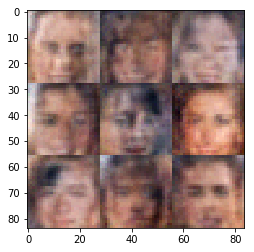

Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 0.9891... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.5112... Generator Loss: 0.4172
Epoch 1/1... Discriminator Loss: 0.9295... Generator Loss: 1.2475


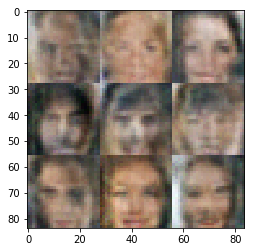

Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 0.9214
Epoch 1/1... Discriminator Loss: 1.0054... Generator Loss: 1.1054
Epoch 1/1... Discriminator Loss: 0.5878... Generator Loss: 2.3808


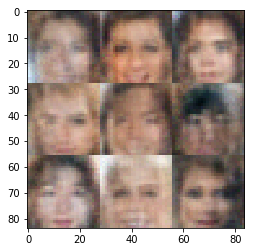

Epoch 1/1... Discriminator Loss: 0.7190... Generator Loss: 1.8631
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.3882
Epoch 1/1... Discriminator Loss: 1.7602... Generator Loss: 0.2688
Epoch 1/1... Discriminator Loss: 0.7218... Generator Loss: 3.2882
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 0.6359


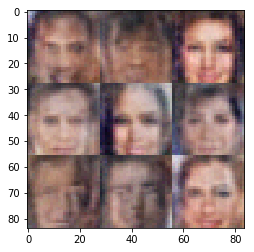

Epoch 1/1... Discriminator Loss: 0.9199... Generator Loss: 1.0250
Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.5220
Epoch 1/1... Discriminator Loss: 1.6729... Generator Loss: 0.3047
Epoch 1/1... Discriminator Loss: 0.7571... Generator Loss: 3.0045


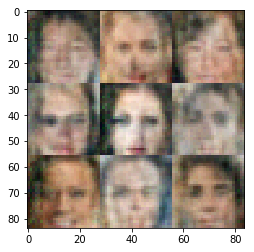

Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.4152
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.3989
Epoch 1/1... Discriminator Loss: 0.6067... Generator Loss: 1.5446


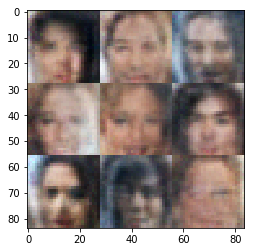

Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 1.4951
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.4563
Epoch 1/1... Discriminator Loss: 0.8005... Generator Loss: 1.3123
Epoch 1/1... Discriminator Loss: 1.9165... Generator Loss: 0.2175


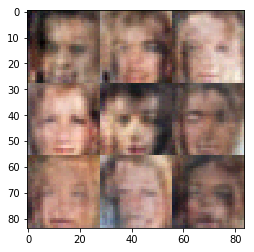

Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 1.2039
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.3944
Epoch 1/1... Discriminator Loss: 0.6885... Generator Loss: 2.8254
Epoch 1/1... Discriminator Loss: 0.5387... Generator Loss: 3.4662


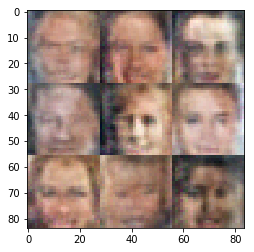

Epoch 1/1... Discriminator Loss: 0.5099... Generator Loss: 2.2542
Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 0.7567... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 0.6828... Generator Loss: 3.1933
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 0.9805


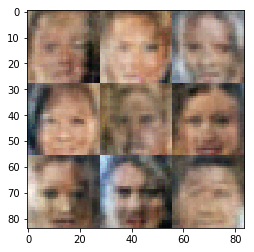

Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.4712
Epoch 1/1... Discriminator Loss: 1.5472... Generator Loss: 0.4168
Epoch 1/1... Discriminator Loss: 0.9582... Generator Loss: 0.9170
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.6812... Generator Loss: 0.3143


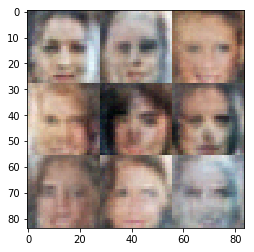

Epoch 1/1... Discriminator Loss: 1.3377... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 0.7182... Generator Loss: 3.3014
Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.4311
Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.5167


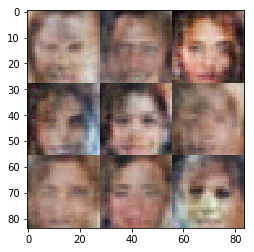

Epoch 1/1... Discriminator Loss: 0.7943... Generator Loss: 1.2672
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 0.6369... Generator Loss: 2.5857
Epoch 1/1... Discriminator Loss: 0.8787... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 0.5886... Generator Loss: 2.5947


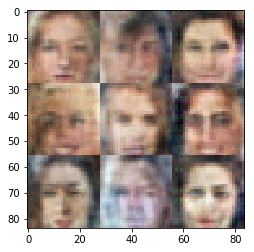

Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.4875
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 2.0278
Epoch 1/1... Discriminator Loss: 0.5366... Generator Loss: 2.7754
Epoch 1/1... Discriminator Loss: 1.5533... Generator Loss: 0.3982
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.5728


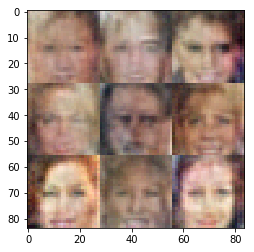

Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 1.9155
Epoch 1/1... Discriminator Loss: 0.5778... Generator Loss: 2.9754
Epoch 1/1... Discriminator Loss: 1.6345... Generator Loss: 0.3557
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.9437
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.5863


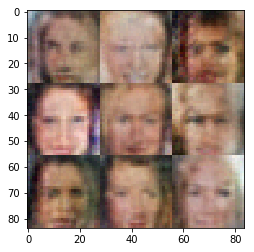

Epoch 1/1... Discriminator Loss: 0.7570... Generator Loss: 3.0674
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.4309
Epoch 1/1... Discriminator Loss: 0.7863... Generator Loss: 2.8982
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.0732... Generator Loss: 0.8571


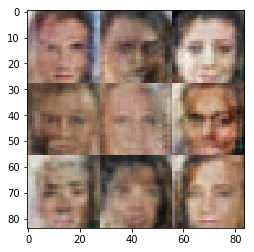

Epoch 1/1... Discriminator Loss: 1.0510... Generator Loss: 1.1412
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.5248
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 0.8043


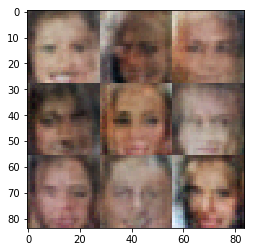

Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.4125
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 0.5889... Generator Loss: 2.7758
Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 2.0494
Epoch 1/1... Discriminator Loss: 1.0620... Generator Loss: 0.9503


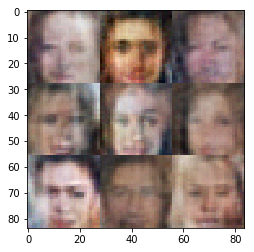

Epoch 1/1... Discriminator Loss: 0.6447... Generator Loss: 1.8987
Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 1.4446
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.5701
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 2.5122
Epoch 1/1... Discriminator Loss: 0.5333... Generator Loss: 3.2024


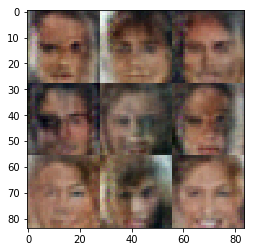

Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 0.8837... Generator Loss: 1.1295
Epoch 1/1... Discriminator Loss: 0.8833... Generator Loss: 1.2653
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.6374


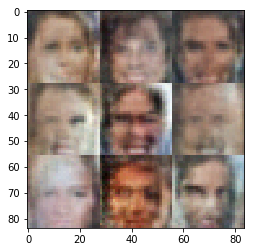

Epoch 1/1... Discriminator Loss: 1.0890... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.5853... Generator Loss: 0.3499
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 0.8835... Generator Loss: 1.0700


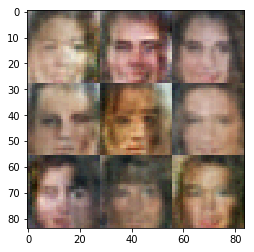

Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 1.5960... Generator Loss: 0.3618
Epoch 1/1... Discriminator Loss: 0.6412... Generator Loss: 2.8338
Epoch 1/1... Discriminator Loss: 1.2621... Generator Loss: 0.4993
Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 1.3207


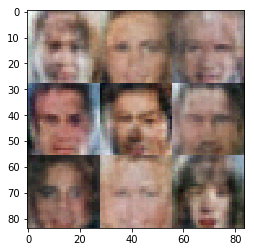

Epoch 1/1... Discriminator Loss: 0.6073... Generator Loss: 3.6537
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 1.4137
Epoch 1/1... Discriminator Loss: 1.4839... Generator Loss: 0.4958
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 0.7632... Generator Loss: 1.8894


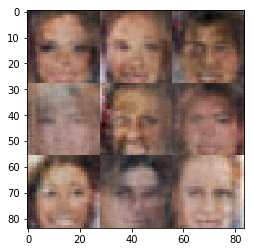

Epoch 1/1... Discriminator Loss: 1.4820... Generator Loss: 0.4020
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.5673... Generator Loss: 0.3467
Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 1.7644
Epoch 1/1... Discriminator Loss: 1.7527... Generator Loss: 0.2825


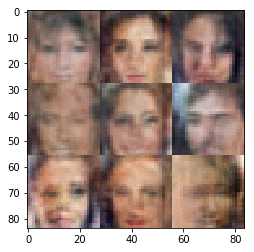

Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.7724
Epoch 1/1... Discriminator Loss: 1.0533... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.7637... Generator Loss: 0.3066
Epoch 1/1... Discriminator Loss: 1.0995... Generator Loss: 1.2475
Epoch 1/1... Discriminator Loss: 0.8252... Generator Loss: 0.9983


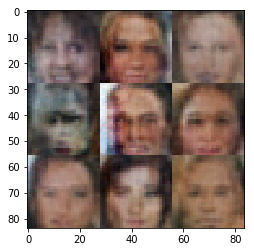

Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 2.3616
Epoch 1/1... Discriminator Loss: 0.6896... Generator Loss: 1.9423
Epoch 1/1... Discriminator Loss: 0.7221... Generator Loss: 1.7656
Epoch 1/1... Discriminator Loss: 1.0034... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.4194


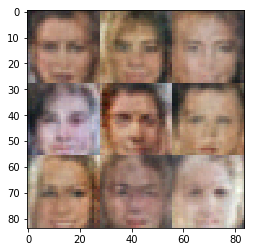

Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 1.4811
Epoch 1/1... Discriminator Loss: 0.5849... Generator Loss: 2.0357
Epoch 1/1... Discriminator Loss: 1.0241... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 0.9041... Generator Loss: 1.1773
Epoch 1/1... Discriminator Loss: 0.4104... Generator Loss: 2.7759


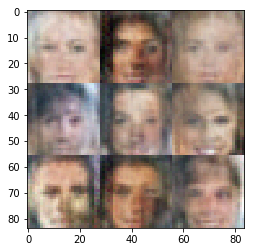

Epoch 1/1... Discriminator Loss: 0.7640... Generator Loss: 1.3377
Epoch 1/1... Discriminator Loss: 0.6526... Generator Loss: 2.5962
Epoch 1/1... Discriminator Loss: 1.7592... Generator Loss: 0.3021
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.0287... Generator Loss: 1.4445


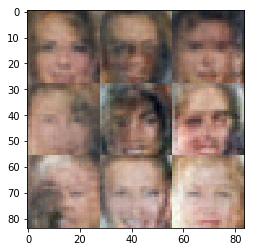

Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 0.8075... Generator Loss: 1.0097
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.4648
Epoch 1/1... Discriminator Loss: 1.0462... Generator Loss: 1.2209
Epoch 1/1... Discriminator Loss: 0.8288... Generator Loss: 1.4583


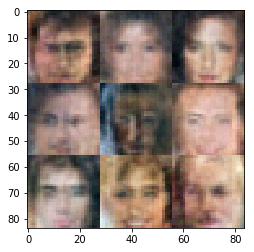

Epoch 1/1... Discriminator Loss: 0.6595... Generator Loss: 2.3845
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.5629
Epoch 1/1... Discriminator Loss: 0.8100... Generator Loss: 1.0235
Epoch 1/1... Discriminator Loss: 0.7363... Generator Loss: 1.3143
Epoch 1/1... Discriminator Loss: 1.0183... Generator Loss: 0.7306


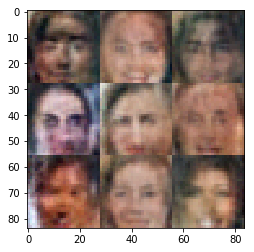

Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.1407
Epoch 1/1... Discriminator Loss: 0.6310... Generator Loss: 2.3811
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.3936
Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 0.3881
Epoch 1/1... Discriminator Loss: 0.8813... Generator Loss: 1.0244


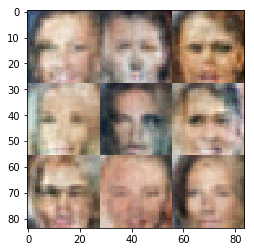

Epoch 1/1... Discriminator Loss: 1.0248... Generator Loss: 0.8829
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.4490
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 1.0809
Epoch 1/1... Discriminator Loss: 1.2914... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.8917... Generator Loss: 0.2571


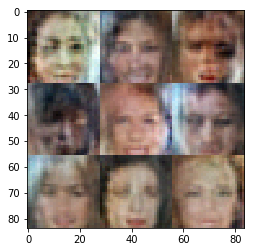

Epoch 1/1... Discriminator Loss: 0.6427... Generator Loss: 1.6667
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.4359
Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 2.1736
Epoch 1/1... Discriminator Loss: 0.6250... Generator Loss: 1.7279
Epoch 1/1... Discriminator Loss: 0.9988... Generator Loss: 0.7357


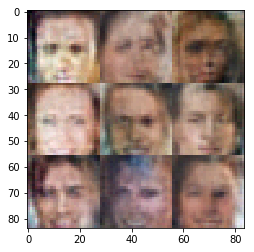

Epoch 1/1... Discriminator Loss: 0.8305... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.2546
Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 0.3727
Epoch 1/1... Discriminator Loss: 0.8609... Generator Loss: 1.1265
Epoch 1/1... Discriminator Loss: 0.9854... Generator Loss: 0.8225


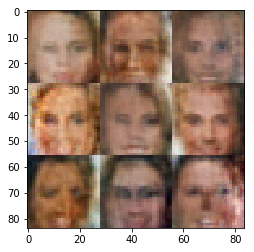

Epoch 1/1... Discriminator Loss: 0.6006... Generator Loss: 4.0434
Epoch 1/1... Discriminator Loss: 0.8649... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 1.1298
Epoch 1/1... Discriminator Loss: 0.6542... Generator Loss: 2.3644
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.4487


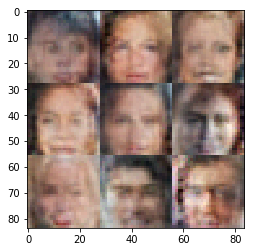

Epoch 1/1... Discriminator Loss: 0.7076... Generator Loss: 1.3164
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.5402
Epoch 1/1... Discriminator Loss: 0.7381... Generator Loss: 2.0986
Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 1.5041


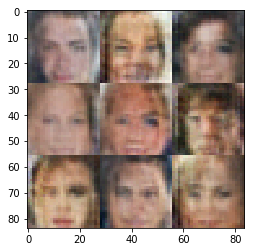

Epoch 1/1... Discriminator Loss: 1.3571... Generator Loss: 0.5378
Epoch 1/1... Discriminator Loss: 1.5297... Generator Loss: 0.3587
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.5624
Epoch 1/1... Discriminator Loss: 0.6530... Generator Loss: 1.3601
Epoch 1/1... Discriminator Loss: 1.5927... Generator Loss: 0.3621


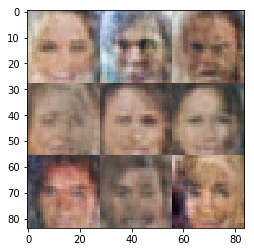

Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.3704
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.5386
Epoch 1/1... Discriminator Loss: 0.8013... Generator Loss: 3.1411
Epoch 1/1... Discriminator Loss: 0.8912... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 0.7022... Generator Loss: 2.0165


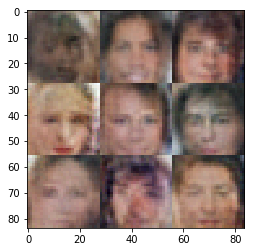

Epoch 1/1... Discriminator Loss: 0.7795... Generator Loss: 1.5385
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.4543
Epoch 1/1... Discriminator Loss: 0.5717... Generator Loss: 2.6954
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.4705
Epoch 1/1... Discriminator Loss: 0.7032... Generator Loss: 1.7707


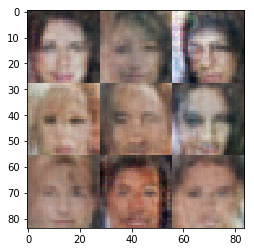

Epoch 1/1... Discriminator Loss: 0.7125... Generator Loss: 1.7189
Epoch 1/1... Discriminator Loss: 1.0501... Generator Loss: 0.8472
Epoch 1/1... Discriminator Loss: 0.8568... Generator Loss: 1.3116
Epoch 1/1... Discriminator Loss: 0.7676... Generator Loss: 1.3701
Epoch 1/1... Discriminator Loss: 0.4806... Generator Loss: 2.7900


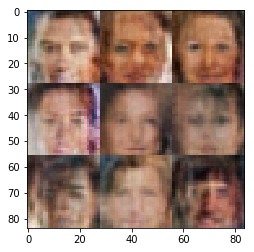

Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.4210
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 0.5670... Generator Loss: 4.7914
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.5160
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 0.6003


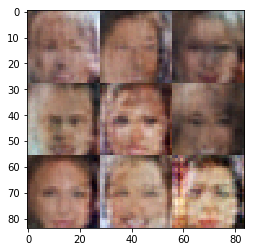

Epoch 1/1... Discriminator Loss: 1.6304... Generator Loss: 0.3287
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 0.7689... Generator Loss: 1.2556
Epoch 1/1... Discriminator Loss: 1.6985... Generator Loss: 0.2968
Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 3.2123


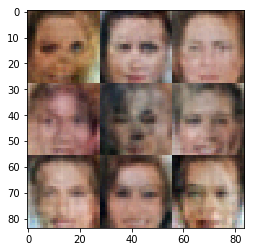

Epoch 1/1... Discriminator Loss: 0.4903... Generator Loss: 2.0013
Epoch 1/1... Discriminator Loss: 0.7519... Generator Loss: 1.3511
Epoch 1/1... Discriminator Loss: 0.9777... Generator Loss: 2.2109
Epoch 1/1... Discriminator Loss: 0.8187... Generator Loss: 1.0727
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.4550


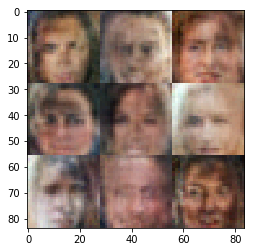

Epoch 1/1... Discriminator Loss: 0.5787... Generator Loss: 3.9339
Epoch 1/1... Discriminator Loss: 1.4323... Generator Loss: 0.4383
Epoch 1/1... Discriminator Loss: 0.5889... Generator Loss: 2.4951
Epoch 1/1... Discriminator Loss: 0.7812... Generator Loss: 1.2222
Epoch 1/1... Discriminator Loss: 0.8429... Generator Loss: 0.9642


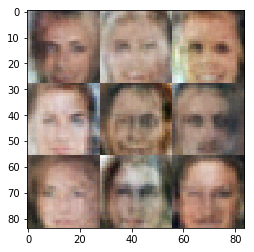

Epoch 1/1... Discriminator Loss: 0.8275... Generator Loss: 1.6330
Epoch 1/1... Discriminator Loss: 0.6255... Generator Loss: 3.9996
Epoch 1/1... Discriminator Loss: 0.8313... Generator Loss: 1.2782
Epoch 1/1... Discriminator Loss: 0.5950... Generator Loss: 1.5086
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.5915


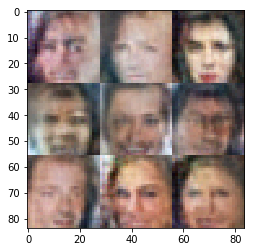

Epoch 1/1... Discriminator Loss: 1.1230... Generator Loss: 0.5387
Epoch 1/1... Discriminator Loss: 0.4855... Generator Loss: 2.8899
Epoch 1/1... Discriminator Loss: 0.7404... Generator Loss: 1.3874
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.4063
Epoch 1/1... Discriminator Loss: 0.7952... Generator Loss: 1.6599


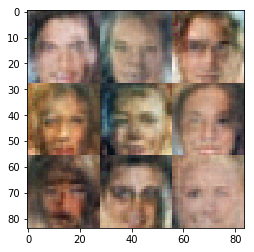

Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 1.6511
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 0.5818... Generator Loss: 2.9842
Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 3.7196


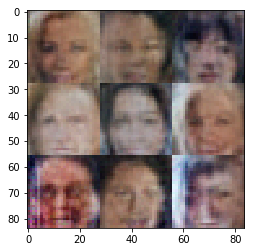

Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 1.6969... Generator Loss: 0.2882
Epoch 1/1... Discriminator Loss: 0.5598... Generator Loss: 2.0077
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 0.5872... Generator Loss: 2.6258


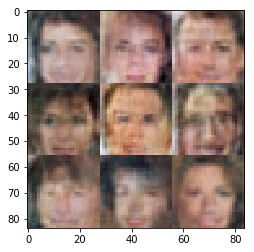

Epoch 1/1... Discriminator Loss: 0.8820... Generator Loss: 1.3185
Epoch 1/1... Discriminator Loss: 0.7168... Generator Loss: 4.1577
Epoch 1/1... Discriminator Loss: 1.0583... Generator Loss: 1.1717
Epoch 1/1... Discriminator Loss: 0.7450... Generator Loss: 1.3095
Epoch 1/1... Discriminator Loss: 1.6544... Generator Loss: 0.3043


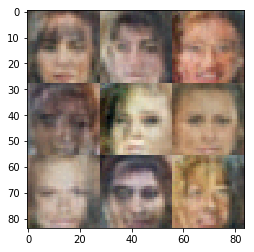

Epoch 1/1... Discriminator Loss: 0.6538... Generator Loss: 1.3736
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.5242
Epoch 1/1... Discriminator Loss: 1.0392... Generator Loss: 0.7970
Epoch 1/1... Discriminator Loss: 0.6070... Generator Loss: 2.8809
Epoch 1/1... Discriminator Loss: 0.6418... Generator Loss: 2.0650


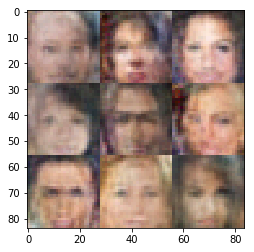

Epoch 1/1... Discriminator Loss: 0.6324... Generator Loss: 1.3388
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 0.8788... Generator Loss: 0.8958
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 1.4639
Epoch 1/1... Discriminator Loss: 0.6649... Generator Loss: 1.4455


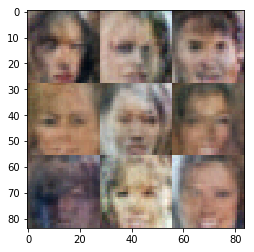

Epoch 1/1... Discriminator Loss: 1.0365... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 0.8118... Generator Loss: 4.6446
Epoch 1/1... Discriminator Loss: 0.4721... Generator Loss: 3.6010
Epoch 1/1... Discriminator Loss: 0.6285... Generator Loss: 2.7727
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.5644


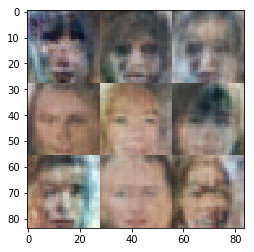

Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 1.0742
Epoch 1/1... Discriminator Loss: 0.6371... Generator Loss: 1.5841
Epoch 1/1... Discriminator Loss: 0.7259... Generator Loss: 1.2665
Epoch 1/1... Discriminator Loss: 0.8807... Generator Loss: 1.1536
Epoch 1/1... Discriminator Loss: 0.9864... Generator Loss: 0.6737


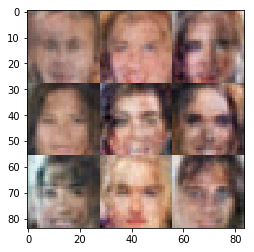

Epoch 1/1... Discriminator Loss: 0.8868... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 0.7107... Generator Loss: 1.3715
Epoch 1/1... Discriminator Loss: 1.1538... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 0.3561... Generator Loss: 3.0194
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 0.9975


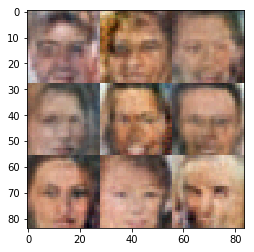

Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 1.8857
Epoch 1/1... Discriminator Loss: 0.6553... Generator Loss: 2.7254
Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 1.2411
Epoch 1/1... Discriminator Loss: 1.3646... Generator Loss: 0.4243
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.6562


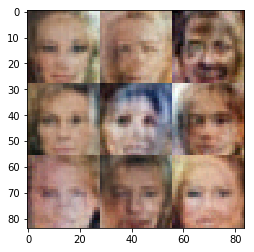

Epoch 1/1... Discriminator Loss: 0.4731... Generator Loss: 3.4214
Epoch 1/1... Discriminator Loss: 0.5549... Generator Loss: 2.1366
Epoch 1/1... Discriminator Loss: 0.5843... Generator Loss: 2.1022
Epoch 1/1... Discriminator Loss: 0.8433... Generator Loss: 0.9698
Epoch 1/1... Discriminator Loss: 0.6019... Generator Loss: 4.1617


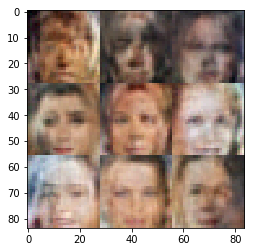

Epoch 1/1... Discriminator Loss: 0.8489... Generator Loss: 0.9946
Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 1.3689
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.4435
Epoch 1/1... Discriminator Loss: 0.5720... Generator Loss: 2.8526
Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 2.4736


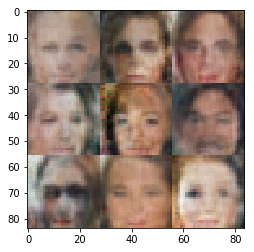

Epoch 1/1... Discriminator Loss: 0.7682... Generator Loss: 1.4622
Epoch 1/1... Discriminator Loss: 0.5163... Generator Loss: 2.1431
Epoch 1/1... Discriminator Loss: 0.4712... Generator Loss: 2.1939
Epoch 1/1... Discriminator Loss: 1.6316... Generator Loss: 0.3076
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 0.6958


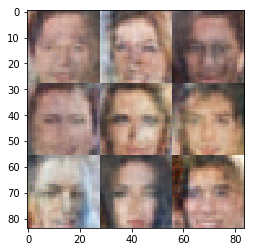

Epoch 1/1... Discriminator Loss: 0.9403... Generator Loss: 0.8278
Epoch 1/1... Discriminator Loss: 0.7083... Generator Loss: 1.6998
Epoch 1/1... Discriminator Loss: 0.6621... Generator Loss: 1.3883
Epoch 1/1... Discriminator Loss: 1.0417... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.5477... Generator Loss: 0.3200


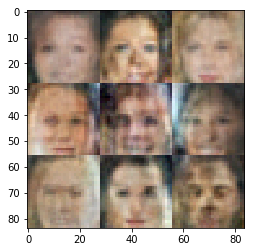

Epoch 1/1... Discriminator Loss: 0.5892... Generator Loss: 1.8509
Epoch 1/1... Discriminator Loss: 0.4807... Generator Loss: 2.7441
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.3872
Epoch 1/1... Discriminator Loss: 0.6436... Generator Loss: 2.7719
Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 0.7902


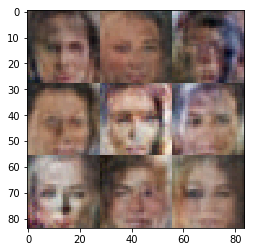

Epoch 1/1... Discriminator Loss: 0.7257... Generator Loss: 2.4062
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 0.4991
Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 1.3620
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 2.2157


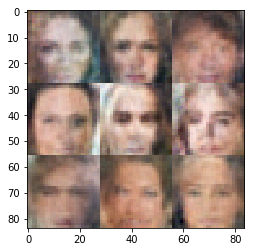

Epoch 1/1... Discriminator Loss: 1.1974... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 0.6314... Generator Loss: 2.0302
Epoch 1/1... Discriminator Loss: 0.9692... Generator Loss: 1.2880
Epoch 1/1... Discriminator Loss: 0.7368... Generator Loss: 1.9032
Epoch 1/1... Discriminator Loss: 0.7673... Generator Loss: 3.8611


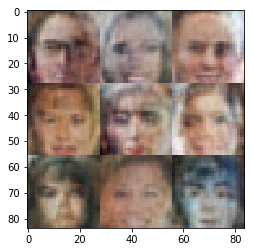

Epoch 1/1... Discriminator Loss: 0.4898... Generator Loss: 2.2916
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.3541
Epoch 1/1... Discriminator Loss: 0.5370... Generator Loss: 2.1895
Epoch 1/1... Discriminator Loss: 1.1064... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 0.8525... Generator Loss: 0.9911


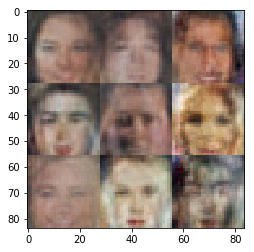

Epoch 1/1... Discriminator Loss: 0.5097... Generator Loss: 2.4999
Epoch 1/1... Discriminator Loss: 1.6334... Generator Loss: 0.3303
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.4947
Epoch 1/1... Discriminator Loss: 0.4301... Generator Loss: 3.2422
Epoch 1/1... Discriminator Loss: 0.7521... Generator Loss: 0.9847


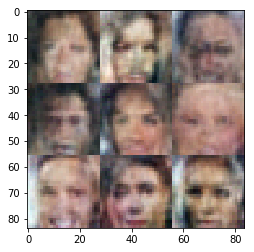

Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 0.7729... Generator Loss: 1.5095
Epoch 1/1... Discriminator Loss: 0.7593... Generator Loss: 1.2073
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.5088
Epoch 1/1... Discriminator Loss: 0.8287... Generator Loss: 1.1303


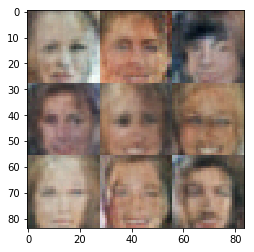

Epoch 1/1... Discriminator Loss: 0.8718... Generator Loss: 1.0093
Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.8090... Generator Loss: 0.2420
Epoch 1/1... Discriminator Loss: 0.4485... Generator Loss: 2.3073
Epoch 1/1... Discriminator Loss: 1.0003... Generator Loss: 0.6846


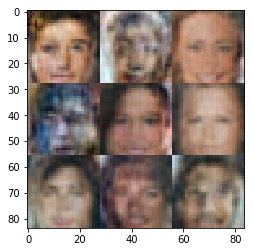

Epoch 1/1... Discriminator Loss: 0.8939... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 1.4831... Generator Loss: 0.4764
Epoch 1/1... Discriminator Loss: 0.6394... Generator Loss: 3.4329
Epoch 1/1... Discriminator Loss: 0.4883... Generator Loss: 4.0382
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.6506


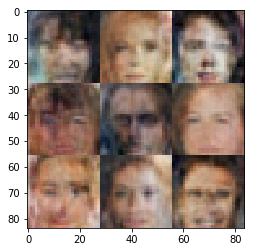

Epoch 1/1... Discriminator Loss: 0.6711... Generator Loss: 1.4329
Epoch 1/1... Discriminator Loss: 0.8746... Generator Loss: 1.0634
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.5368
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.3985
Epoch 1/1... Discriminator Loss: 0.6806... Generator Loss: 2.9217


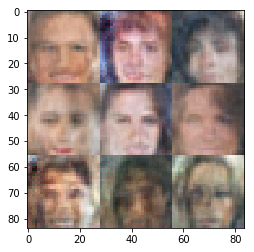

Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 0.6051... Generator Loss: 1.7934
Epoch 1/1... Discriminator Loss: 0.4743... Generator Loss: 4.3609
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 1.1288
Epoch 1/1... Discriminator Loss: 0.8226... Generator Loss: 2.2119


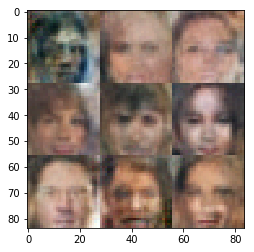

Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 0.9672... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 0.6021... Generator Loss: 1.7184
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.3540


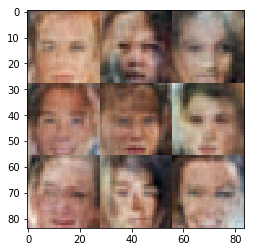

Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.5873
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 1.0873
Epoch 1/1... Discriminator Loss: 0.4009... Generator Loss: 5.1377
Epoch 1/1... Discriminator Loss: 0.5799... Generator Loss: 2.9469
Epoch 1/1... Discriminator Loss: 0.8135... Generator Loss: 1.0832


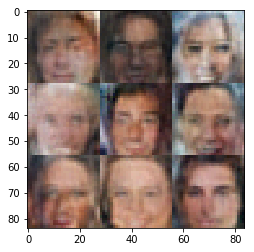

Epoch 1/1... Discriminator Loss: 0.8255... Generator Loss: 1.5538
Epoch 1/1... Discriminator Loss: 0.4555... Generator Loss: 1.9233
Epoch 1/1... Discriminator Loss: 0.5402... Generator Loss: 2.7279
Epoch 1/1... Discriminator Loss: 0.4744... Generator Loss: 2.5424
Epoch 1/1... Discriminator Loss: 1.0413... Generator Loss: 0.6527


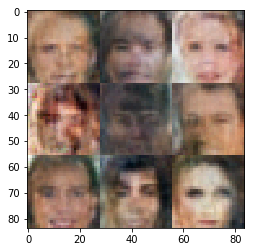

Epoch 1/1... Discriminator Loss: 0.6393... Generator Loss: 1.9140
Epoch 1/1... Discriminator Loss: 0.6336... Generator Loss: 1.5533
Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 1.2358
Epoch 1/1... Discriminator Loss: 0.4101... Generator Loss: 3.2785
Epoch 1/1... Discriminator Loss: 0.7608... Generator Loss: 1.2516


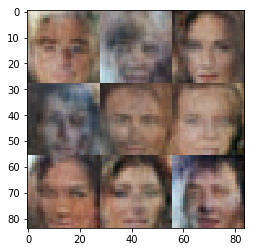

Epoch 1/1... Discriminator Loss: 0.7390... Generator Loss: 1.9470
Epoch 1/1... Discriminator Loss: 0.5977... Generator Loss: 2.1684
Epoch 1/1... Discriminator Loss: 0.6290... Generator Loss: 1.7406
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 0.6060... Generator Loss: 3.9316


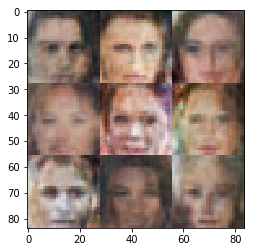

Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.4855
Epoch 1/1... Discriminator Loss: 0.9187... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 0.6233... Generator Loss: 2.4970
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.6595


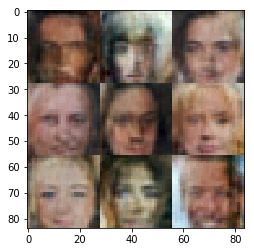

Epoch 1/1... Discriminator Loss: 0.8336... Generator Loss: 0.9436
Epoch 1/1... Discriminator Loss: 0.8433... Generator Loss: 1.0683
Epoch 1/1... Discriminator Loss: 0.7267... Generator Loss: 1.8119
Epoch 1/1... Discriminator Loss: 0.6174... Generator Loss: 2.0468
Epoch 1/1... Discriminator Loss: 0.5670... Generator Loss: 2.0247


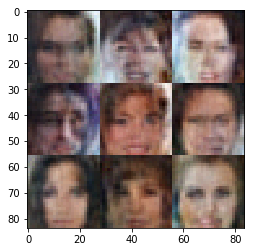

Epoch 1/1... Discriminator Loss: 0.5233... Generator Loss: 3.2953
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 0.6031... Generator Loss: 1.8868
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.4790
Epoch 1/1... Discriminator Loss: 0.5563... Generator Loss: 3.6197


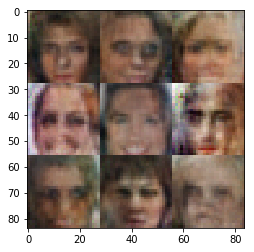

Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.4090
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.0983
Epoch 1/1... Discriminator Loss: 0.9872... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 0.3372
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 0.8582


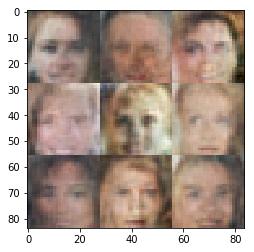

Epoch 1/1... Discriminator Loss: 1.6244... Generator Loss: 0.3563
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.0637
Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 0.6964... Generator Loss: 1.1680
Epoch 1/1... Discriminator Loss: 0.6785... Generator Loss: 2.7924


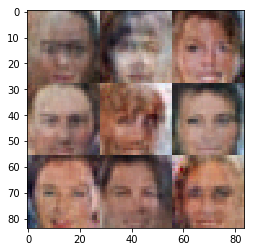

Epoch 1/1... Discriminator Loss: 0.5961... Generator Loss: 3.2328
Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 0.3677
Epoch 1/1... Discriminator Loss: 0.6224... Generator Loss: 1.6755
Epoch 1/1... Discriminator Loss: 1.1910... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 0.6507... Generator Loss: 2.3834


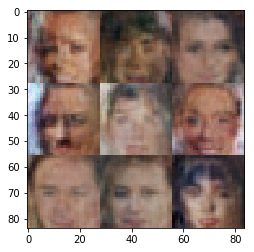

Epoch 1/1... Discriminator Loss: 0.6498... Generator Loss: 2.3757
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.4505
Epoch 1/1... Discriminator Loss: 0.5116... Generator Loss: 2.5389
Epoch 1/1... Discriminator Loss: 0.4389... Generator Loss: 2.7161
Epoch 1/1... Discriminator Loss: 1.6095... Generator Loss: 0.3765


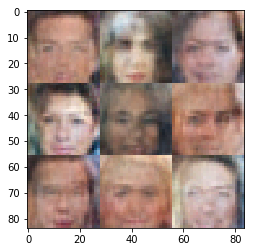

Epoch 1/1... Discriminator Loss: 0.4331... Generator Loss: 2.2679
Epoch 1/1... Discriminator Loss: 0.9919... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 0.5613... Generator Loss: 3.1523
Epoch 1/1... Discriminator Loss: 0.7665... Generator Loss: 1.4623
Epoch 1/1... Discriminator Loss: 1.5645... Generator Loss: 0.3515


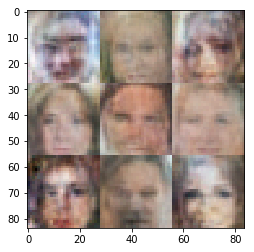

Epoch 1/1... Discriminator Loss: 0.7482... Generator Loss: 1.5381
Epoch 1/1... Discriminator Loss: 0.5861... Generator Loss: 1.7194
Epoch 1/1... Discriminator Loss: 1.5854... Generator Loss: 0.3222
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.0795... Generator Loss: 0.6887


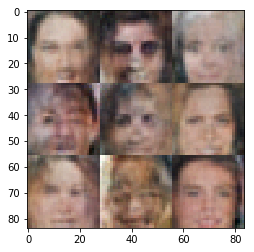

Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.5304
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 1.1469
Epoch 1/1... Discriminator Loss: 0.9687... Generator Loss: 0.7878


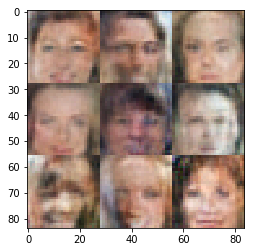

Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.4115
Epoch 1/1... Discriminator Loss: 0.5256... Generator Loss: 3.4247
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.5867
Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 1.3722
Epoch 1/1... Discriminator Loss: 0.7404... Generator Loss: 1.4774


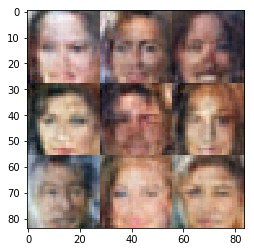

Epoch 1/1... Discriminator Loss: 0.5976... Generator Loss: 2.0908
Epoch 1/1... Discriminator Loss: 0.7805... Generator Loss: 1.1297
Epoch 1/1... Discriminator Loss: 0.6136... Generator Loss: 1.4353


In [44]:
batch_size = 32
z_dim = 200
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.